<h1>Summary of all results from nova project, plus hierarchical model</h1>

In [490]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, glob
plt.style.use('thomas')
# check files on github: changed version of original at https://github.com/grburgess/bayescorner
import bayescorner
from scipy.ndimage import gaussian_filter1d as smooth
from tqdm.autonotebook import tqdm as tqdm

In [491]:
plt.style.use('thomas')

<h3>All .npz results files can be found at ..., formatted to work with this notebook:</h3>

In [492]:
# change this to your results directory
results_dir = '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/na22/'

<h3>Analysis of one object for 22Na (here: V5113 Sgr):</h3>

In [493]:
with np.load(results_dir+'098_V5113_Sgr/save_StanFit_mass_NovaV5113_Sgr_final.npz') as content:
    flux_tmp = content['fit_tmp_flux']
    dist_tmp = content['fit_tmp_dist']
    lgM_tmp = content['fit_tmp_lgM']

<h3>For each object we should have >= 1000 samples:</h3>

In [494]:
flux_tmp.shape,dist_tmp.shape,lgM_tmp.shape

((1000, 1), (1000, 1), (1000, 1))

<h3>bayescorner is similar to corner, just with a few fancy extras (if bayescorner is not working, use corner):</h3>

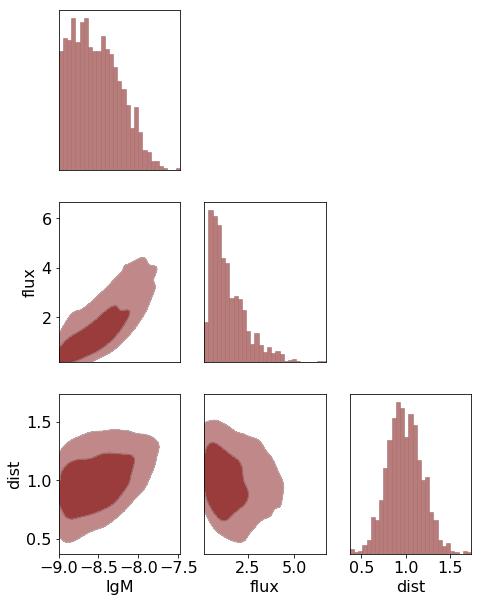

In [495]:
pl = bayescorner.bayescorner(np.vstack([flux_tmp[:,0],dist_tmp[:,0],lgM_tmp[:,0]]),
                        param_names=['flux','dist','lgM'],levels=[0,0.683,0.954]);

<h3>This <em>is</em> the result. We can extract moments and percentiles of the marginalised distributions (diagionals) to get the information we want to quote in the paper in the end, e.g. mean, std, upper bounds (remember that the distance is a nuisance parameter and we actually measure flux, but which converts to an ejected mass):</h3>

In [496]:
print('Margenalised over distance prior ('+str('%.1f' % (np.mean(dist_tmp[:,0])))+'+/-'+\
      str('%.1f' % (np.std(dist_tmp[:,0])))+') kpc yields:')
print('Upper bound on 1.275 MeV flux (x 1e-5 ph/cm2/s): '+\
      str('%.1f' % (np.percentile(flux_tmp[:,0],99.85)))+'.')
print('Upper bound on ejected Na-22 mass (x 1e-8 Msun): '+\
      str('%.2f' % (10**np.percentile(lgM_tmp[:,0],99.85)*1e8))+'.')

Margenalised over distance prior (1.0+/-0.2) kpc yields:
Upper bound on 1.275 MeV flux (x 1e-5 ph/cm2/s): 5.7.
Upper bound on ejected Na-22 mass (x 1e-8 Msun): 2.05.


<h3>Now we read in our catalogue as usual and extract the information that we need for summary plots:</h3>

In [497]:
# basically copied from the comet python script
print('| Reading in catalogue ...')
print('|')

# read in nova catalogue
data_frame = pd.read_csv('INTEGRAL_novae_wTimes.csv')

print('| Select appropriate novae ...')
print('|')

# define good novae according to selections from catalogue
good_novae = np.where(~np.isnan(data_frame['IJD']) &
                      (data_frame['Dist. \n(kpc)']+data_frame['Dist. Err. (kpc)'] < 25) &
                      ((data_frame['Var. type'] == 'N') |
                       (data_frame['Var. type'] == 'NAa') |
                       (data_frame['Var. type'] == 'NB') |
                       (data_frame['Var. type'] == 'NC') |
                       (data_frame['Var. type'] == 'NTS')))[0]

# information needed later
# objects identifiers
names    = data_frame['Name'][good_novae].values
# object distances and uncertainties
dist     = data_frame['Dist. \n(kpc)'][good_novae].values
dist_err = data_frame['Dist. Err. (kpc)'][good_novae].values

print('| Done.')

| Reading in catalogue ...
|
| Select appropriate novae ...
|
| Done.


In [498]:
# selection if we dont know the distance
unknown_dist = 8.179

<h3>Now we search in the results directory for .npz fiels that have the ending "final.npz" and put them in a list to read in a next step:</h3>

In [499]:
result_files_final = []

for subdir, dirs, files in os.walk(results_dir):
    for file in files:
        if os.path.join(subdir, file).endswith('final.npz'):
            result_files_final.append(os.path.join(subdir, file))

<h3>97 individual novae, plus 1 diffuse emission</h3>

In [500]:
len(result_files_final)

98

<h3>Ee make an array of that list, sort it, and ignore the diffuse emission for the moment:</h3>

In [501]:
result_files_final = np.array(result_files_final)
sdx = np.argsort(result_files_final)
result_files_final = result_files_final[sdx]
result_files_final = result_files_final[1:]

In [503]:
result_files_final[-4:]

array(['/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/na22/098_V5113_Sgr/save_StanFit_mass_NovaV5113_Sgr_final.npz',
       '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/na22/099_V4744_Sgr/save_StanFit_mass_NovaV4744_Sgr_final.npz',
       '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/na22/100_V2540_Oph/save_StanFit_mass_NovaV2540_Oph_final.npz',
       '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/na22/101_V4743_Sgr/save_StanFit_mass_NovaV4743_Sgr_final.npz'],
      dtype='<U147')

<h1>Plot for lgM vs. distance (including flux), and comparison to literature values (theory and measurement):</h1>

<h3>Helper variables, arrays, and functions:</h3>

In [504]:
# some colors
color_unknown = 'black'
see_colors = ['firebrick','red','purple','xkcd:cobalt blue','cyan','lime']

In [505]:
# distances
d_arr = np.logspace(-1,2,500)

In [506]:
# function that converts flux and distance to mass
def const_flux22(d,f):
    return np.log10(d**2*f/3838)

In [507]:
# annotations
plot_fluxes = np.array([1e-2,1e-3,1e-4,1e-5,1e-6,3e-5,3e-4,3e-6,3e-3,3e-7])
text_fluxes = np.array([r'$10^{-2}$',r'$10^{-3}$',r'$10^{-4}$',r'$10^{-5}$',r'$10^{-6}$'])
posi_fluxes = np.array([[0.5,0.5,0.5,1.0*0.8,3.2*0.8],[-5.9,-6.9,-7.9,-8.5,-8.5]])

In [508]:
# Starrfield+2009 22Na yields for ONe novae
# 1.25 MSol WD
model_name_S09_125 = np.array(['P1995A','P1995B','P1995C','S1998','I2001','I2005A','I2005B'])
M_ej_S09_125 = np.array([5.0,4.8,1.8,1.5,0.7,1.5,3.3])*1e-5
X_Na22_S09_125 = np.array([np.nan,np.nan,4.8,7.3,6.8,4.5,np.nan])*1e-3
M_ej22_S09_125 = M_ej_S09_125*X_Na22_S09_125

In [509]:
# 1.35 MSol WD
model_name_S09_135 = np.array(['P1995A','P1995B','P1995C','S1998','I2001','I2005A','I2005B'])
M_ej_S09_135 = np.array([3.3,4.1,2.3,2.3,2.3,1.7,4.3])*1e-5
X_Na22_S09_135 = np.array([np.nan,np.nan,3.5,5.1,3.0,2.3,np.nan])*1e-2
M_ej22_S09_135 = M_ej_S09_135*X_Na22_S09_135

<h3>Plot that reads in results iteratively and plots them in various ways:</h3>

<h3>Check which objects are interesting by flux and mass:</h3>

33 038 V1535_Sco 2.432036786690651


/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/bayescorner/compute_sigma_level.py:21: RuntimeWarning: divide by zero encountered in log
  logL = np.log(L)


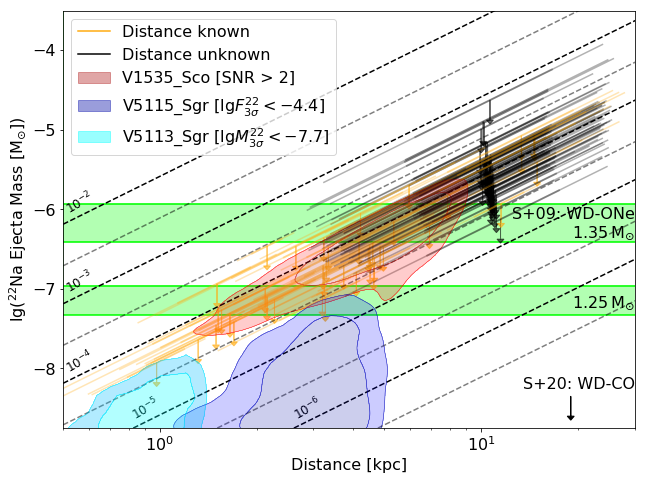

In [510]:
# lists for flux, mass, dist, and name of objects for plot
flux_limits = []
mass_limits = []
distances_f = []
obj_names_f = []

# definition of figure
fig, ax = plt.subplots(figsize=(10.24,7.68))
ax.set_xlim(0.5,30)
ax.set_ylim(-8.75,-3.5)
ax.set_xscale('log')
ax.set_xlabel('Distance [kpc]')
ax.set_ylabel(r'lg($^{22}\mathrm{Na}$ Ejecta Mass [$\mathrm{M_{\odot}}$])')

# counting variable for how many objects get a full posterior (SNR>2)
cnt = 0

# upper bounds
perc = 99.85

# empty plot with only indication of fluxes as dashed lines
for i in range(len(plot_fluxes)):
    if i < 5:
        ax.plot(d_arr,const_flux22(d_arr,plot_fluxes[i]),color='black',linestyle='--')
        ax.text(posi_fluxes[0,i],posi_fluxes[1,i],text_fluxes[i],rotation=30,fontsize=12)
    else:
        ax.plot(d_arr,const_flux22(d_arr,plot_fluxes[i]),color='black',linestyle='--',alpha=0.5)
    
    
# loop over objects
for i in range(len(result_files_final)):
    # as above
    with np.load(result_files_final[i]) as content:
        flux_tmp = content['fit_tmp_flux']
        dist_tmp = content['fit_tmp_dist']
        lgM_tmp = content['fit_tmp_lgM']    

    # calculate values and append to lists
    flux_limits.append(np.percentile(flux_tmp[:,0],perc)*1e-5)
    mass_limits.append(np.percentile(10**lgM_tmp[:,0],perc))
    distances_f.append(np.mean(dist_tmp[:,0]))
    # names from file name basically
    obj_names_f.append(result_files_final[i].split(results_dir)[1].split('/')[0][4:])
    
    # if SNR < 2, just plot upper limit as line
    if (np.median(flux_tmp[:,0])/np.std(flux_tmp[:,0]) < 2):
        # distances conversion for upper bounds
        d_med = np.median(dist_tmp[:,0])
        d_std = np.std(dist_tmp[:,0])
        dm_min1 = np.percentile(dist_tmp[:,0],50-68.3/2)
        dm_max1 = np.percentile(dist_tmp[:,0],50+68.3/2)
        dm_min2 = np.percentile(dist_tmp[:,0],50-95.4/2)
        dm_max2 = np.percentile(dist_tmp[:,0],50+95.4/2)
        ddx = np.where((dist_tmp[:,0] > dm_min1) & (dist_tmp[:,0] < dm_max1))
        ddxm1 = np.where((dist_tmp[:,0] > dm_min2) & (dist_tmp[:,0] < dm_min1))
        ddxp1 = np.where((dist_tmp[:,0] > dm_max1) & (dist_tmp[:,0] < dm_max2))

        lgM_med = np.percentile(lgM_tmp[ddx,0],99)
        lgMm_min1 = 2*np.log10(dm_min1)-2*np.log10(d_med)+np.percentile(lgM_tmp[ddx,0],99)
        lgMm_max1 = 2*np.log10(dm_max1)-2*np.log10(d_med)+np.percentile(lgM_tmp[ddx,0],99)
        lgMm_min2 = 2*np.log10(dm_min2)-2*np.log10(d_med)+np.percentile(lgM_tmp[ddx,0],99)
        lgMm_max2 = 2*np.log10(dm_max2)-2*np.log10(d_med)+np.percentile(lgM_tmp[ddx,0],99)

        # if a source distance is unknown (roughly)
        if ((d_med > 9.5) & (d_med < 11.5)):
            ax.arrow(d_med, lgM_med, 0, -0.25, head_width=0.05*d_med, head_length=0.05, fc='k', ec='k',alpha=0.6)
            ax.plot([dm_min1,dm_max1],[lgMm_min1,lgMm_max1],'k-',alpha=0.3,linewidth=2)
            ax.plot([dm_min2,dm_max2],[lgMm_min2,lgMm_max2],'k-',alpha=0.3)
        else:
            ax.arrow(d_med, lgM_med, 0, -0.25, head_width=0.05*d_med, head_length=0.05, fc='xkcd:yellowish orange', ec='xkcd:yellowish orange',alpha=0.6)
            ax.plot([dm_min1,dm_max1],[lgMm_min1,lgMm_max1],color='xkcd:yellowish orange',linestyle='-',alpha=0.3,linewidth=2)
            ax.plot([dm_min2,dm_max2],[lgMm_min2,lgMm_max2],color='xkcd:yellowish orange',linestyle='-',alpha=0.3)
            
        # example posterior for best flux limit (index looked up before; see below)
        if (i == 85):
            d_med = np.median(dist_tmp[:,0])
            d_std = np.std(dist_tmp[:,0])
            
            xbins, ybins, sigma = bayescorner.compute_sigma_level.compute_sigma_level(
            dist_tmp[:,0], lgM_tmp[:,0], ymin=-9.5, ymax=-4, xmin=0, xmax=40, nbins=200)
        
            known_color = see_colors[cnt]
            ax.contourf(xbins, ybins, sigma, levels=[0,0.683,0.9], colors=['xkcd:cobalt blue','blue'], alpha=.2,zorder=1000)
            ax.contour(xbins,ybins,sigma,levels=[0.683,0.9], colors='xkcd:cobalt blue',linewidths=0.5)
            ax.fill_between(np.repeat(100,5),np.repeat(-100,5), color='xkcd:cobalt blue', alpha=.4,
                           label=result_files_final[i].split(results_dir)[1].split('/')[0][4:]+
                           str(r' [$\lg F_{3\sigma}^{22} < -4.4$]'))
            
        # example limit for best mass limit (index looked up before; see below)
        if (i == 93):
            d_med = np.median(dist_tmp[:,0])
            d_std = np.std(dist_tmp[:,0])
            
            xbins, ybins, sigma = bayescorner.compute_sigma_level.compute_sigma_level(
            dist_tmp[:,0], lgM_tmp[:,0], ymin=-9.5, ymax=-4, xmin=0, xmax=40, nbins=200)
        
            known_color = see_colors[cnt]#[np.int(np.random.rand()*5)]#plt.cm.jet(np.random.rand(3))
            ax.contourf(xbins, ybins, sigma, levels=[0,0.683,0.9], colors=['cyan','deepskyblue'], alpha=.3,zorder=1000)
            ax.contour(xbins,ybins,sigma,levels=[0.683,0.9], colors='cyan',linewidths=0.5)
            ax.fill_between(np.repeat(100,5),np.repeat(-100,5), color='cyan', alpha=.4,
                           label=result_files_final[i].split(results_dir)[1].split('/')[0][4:]+
                           str(r' [$\lg M_{3\sigma}^{22} < -7.7$]'))
        
    else:
        
        d_med = np.median(dist_tmp[:,0])
        d_std = np.std(dist_tmp[:,0])
        print(i,
              result_files_final[i].split(results_dir)[1][0:3],
              result_files_final[i].split(results_dir)[1].split('/')[0][4:],
              np.median(flux_tmp[:,0])/np.std(flux_tmp[:,0]))
        xbins, ybins, sigma = bayescorner.compute_sigma_level.compute_sigma_level(
        dist_tmp[:,0], lgM_tmp[:,0], ymin=-9.5, ymax=-4, xmin=0, xmax=40, nbins=200)

        known_color = see_colors[cnt:cnt+2]#[np.int(np.random.rand()*5)]#plt.cm.jet(np.random.rand(3))
        ax.contourf(xbins, ybins, sigma, levels=[0,0.683,0.9], colors=known_color, alpha=.2,zorder=1000)
        ax.contour(xbins,ybins,sigma,levels=[0.683,0.9], colors=known_color,linewidths=0.5)
        ax.fill_between(np.repeat(100,5),np.repeat(-100,5), color=known_color, alpha=.4,
                       label=result_files_final[i].split(results_dir)[1].split('/')[0][4:]+
                       str(r' [SNR > 2]'))

        cnt += 1
        
        
ax.plot([100,100],[-10,-10], color='xkcd:yellowish orange',alpha=1,label='Distance known')
ax.plot([100,100],[-10,-10], color='black',alpha=1,label='Distance unknown')
    
ax.legend()

# now theoretical and measured values
ax.axhline(np.log10(M_ej22_S09_125[3]),color='lime',zorder=-1000)
ax.axhline(np.log10(M_ej22_S09_125[4]),color='lime',zorder=-1000)
ax.fill_between([0.5,0.5,30,50,0.5],
                [np.log10(M_ej22_S09_125[3]),np.log10(M_ej22_S09_125[4]),
                 np.log10(M_ej22_S09_125[4]),np.log10(M_ej22_S09_125[3]),
                 np.log10(M_ej22_S09_125[3])],color='lime',alpha=0.3,zorder=-1000)
ax.text(30,-7.175,r'$1.25\,\mathrm{M_{\odot}}$',
        horizontalalignment='right',verticalalignment='center')

ax.axhline(np.log10(M_ej22_S09_135[3]),color='lime',zorder=-1000)
ax.axhline(np.log10(M_ej22_S09_135[5]),color='lime',zorder=-1000)
ax.fill_between([0.5,0.5,30,50,0.5],
                [np.log10(M_ej22_S09_135[3]),np.log10(M_ej22_S09_135[5]),
                 np.log10(M_ej22_S09_135[5]),np.log10(M_ej22_S09_135[3]),
                 np.log10(M_ej22_S09_135[3])],color='lime',alpha=0.3,zorder=-1000)
ax.text(30,-6.2,'S+09: WD-ONe\n'+r'$1.35\,\mathrm{M_{\odot}}$',
        horizontalalignment='right',verticalalignment='center')

ax.text(30,-8.2,'S+20: WD-CO',
        horizontalalignment='right',verticalalignment='center')
ax.arrow(19, -8.35, 0, -0.25, head_width=0.05*19, head_length=0.05, fc='black', ec='black',alpha=1.0)

plt.savefig('Summary_plot_22Na_lgM_dist_flux.pdf')

flux_limits = np.array(flux_limits)
mass_limits = np.array(mass_limits)
distances_f = np.array(distances_f)

obj_names_f = np.array(obj_names_f)

In [511]:
low_flux_idx = flux_limits < 4e-5 # value set by hand
print(np.where(low_flux_idx == True))
print(flux_limits[low_flux_idx])
print(mass_limits[low_flux_idx])
print(distances_f[low_flux_idx])
print(obj_names_f[low_flux_idx])

(array([35, 85, 90]),)
[2.87607435e-05 3.57874171e-05 3.82955618e-05]
[2.57865368e-06 1.25699317e-07 2.42585014e-06]
[12.06246634  3.27894358 11.85751061]
['V2659_Cyg' 'V5115_Sgr' 'DE_Cir']


In [512]:
low_mass_idx = mass_limits < 5e-8 # value set by hand
print(np.where(low_mass_idx == True))
print(flux_limits[low_mass_idx])
print(mass_limits[low_mass_idx])
print(distances_f[low_mass_idx])
print(obj_names_f[low_mass_idx])

(array([76, 81, 93]),)
[6.22201663e-05 6.55939765e-05 5.73036501e-05]
[4.79502352e-08 4.92437315e-08 2.04895369e-08]
[1.32985755 1.4939042  0.98631701]
['V1280_Sco' 'V5117_Sgr' 'V5113_Sgr']


<h3>Accurate limits of chosen sources:</h3>

In [513]:
print('Upper bound on 1.275 MeV flux (lg-units) of V5115 Sgr: '+\
      str('%.1f' % (np.log10(flux_limits[85]))+'.'))
print('Upper bound on ejected Na-22 mass (lg-units) of V5113 Sgr: '+\
      str('%.1f' % (np.log10(mass_limits[93]))+'.'))

Upper bound on 1.275 MeV flux (lg-units) of V5115 Sgr: -4.4.
Upper bound on ejected Na-22 mass (lg-units) of V5113 Sgr: -7.7.


<h3>And interesting sources to discuss in the paper by comparison to theory values:</h3>

In [514]:
# ejecta mass limit higher than lower limit of theory prediction of 1.35 solar mass WD
obj_names_f[np.where(mass_limits < np.nanmin(M_ej22_S09_135))]

array(['V5668_Sgr', 'V959_Mon', 'V5589_Sgr', 'V5588_Sgr', 'V2674_Oph',
       'V2672_Oph', 'V2467_Cyg', 'V2615_Oph', 'V1280_Sco', 'V5558_Sgr',
       'V2576_Oph', 'V5117_Sgr', 'V1047_Cen', 'V382_Nor', 'V5115_Sgr',
       'V5116_Sgr', 'V1187_Sco', 'V5113_Sgr'], dtype='<U9')

<h3>quite some objects... need to exclude some for discussion because not all of them are (known to be) ONe novae</h3>

In [515]:
# ejecta mass limit higher than lower limit of theory prediction of 1.25 solar mass WD
obj_names_f[np.where(mass_limits < np.nanmin(M_ej22_S09_125))]

array(['V5113_Sgr'], dtype='<U9')

<h3>this would only give V5113 Sgr, maybe use mean of prediction:</h3>

In [516]:
# ejecta mass limit higher than mean of theory prediction of 1.25 solar mass WD
obj_names_f[np.where(mass_limits < np.nanmean(M_ej22_S09_125))]

array(['V1280_Sco', 'V5117_Sgr', 'V5113_Sgr'], dtype='<U9')

<h3>now that's a list we can work with ... later</h3>

<h3>Diffuse emission in the Na-22 case:</h3>

In [517]:
with np.load(results_dir+'000_Diffuse_Emission/save_StanFit_mass_NovaDiffuse_Emission_final.npz') as content:
    flux_tmp = content['fit_tmp_flux']
    R_CN_tmp = content['fit_tmp_R_CN']
    lgM_tmp = content['fit_tmp_lgM']
    #Abg_lines_tmp = content['fit_tmp_Abg_lines']
    #Abg_conti_tmp = content['fit_tmp_Abg_conti']

In [518]:
flux_tmp.shape,R_CN_tmp.shape

((1000, 1), (1000,))

<h3>Quick summary:</h3>

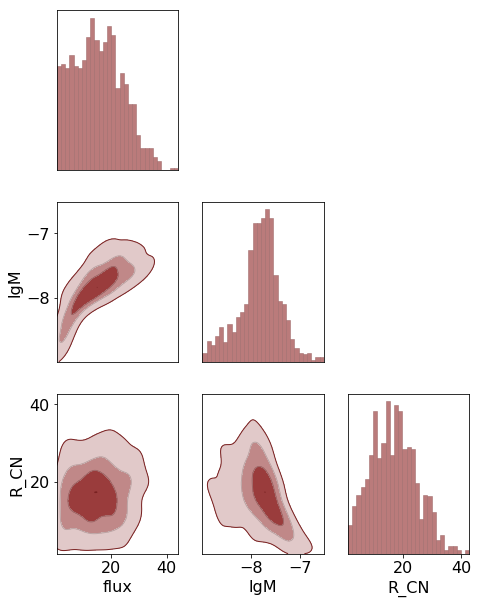

In [519]:
bayescorner.bayescorner(np.vstack([lgM_tmp[:,0],R_CN_tmp[:],flux_tmp[:,0]]),
                        param_names=['lgM','R_CN','flux'],levels=[0.001,0.30,0.60,0.90]);

<h1>Fancy plot with theory values, etc. (but basically the same):</h1>

<h3>Bounds to quote and for plot</h3>

In [520]:
# prior for diffuse Na-22 flux (Wang+2020)
F_conti_set = 7.6 + np.random.randn(1000)*2.5

In [521]:
flux_bounds_tmp = np.percentile(np.abs(flux_tmp[:,0]-F_conti_set),np.array([2.5,50,97.5]))*1e-5
flux_bounds_tmp

array([3.24057645e-06, 7.63117105e-05, 2.47586954e-04])

In [522]:
rcn_bounds_tmp = np.percentile(R_CN_tmp,np.array([2.5,50,97.5]))
rcn_bounds_tmp

array([ 3.5489322 , 16.79584646, 31.94534297])

In [523]:
mass_bounds_tmp = 10**np.percentile(lgM_tmp[:,0],np.array([2.5,50,97.5]))*1e8
mass_bounds_tmp

array([0.17483109, 1.60910783, 8.59745685])

In [524]:
# make contour levels
xbins, ybins, sigma = bayescorner.compute_sigma_level.compute_sigma_level(
    10**lgM_tmp[:,0]*1e8, R_CN_tmp, ymin=0, ymax=50, xmin=0, xmax=20, nbins=50)

In [525]:
# helper array
lgM_arr = 10**np.arange(-10,-5,0.05)*1e8

<h3>ANd plot ...</h3>

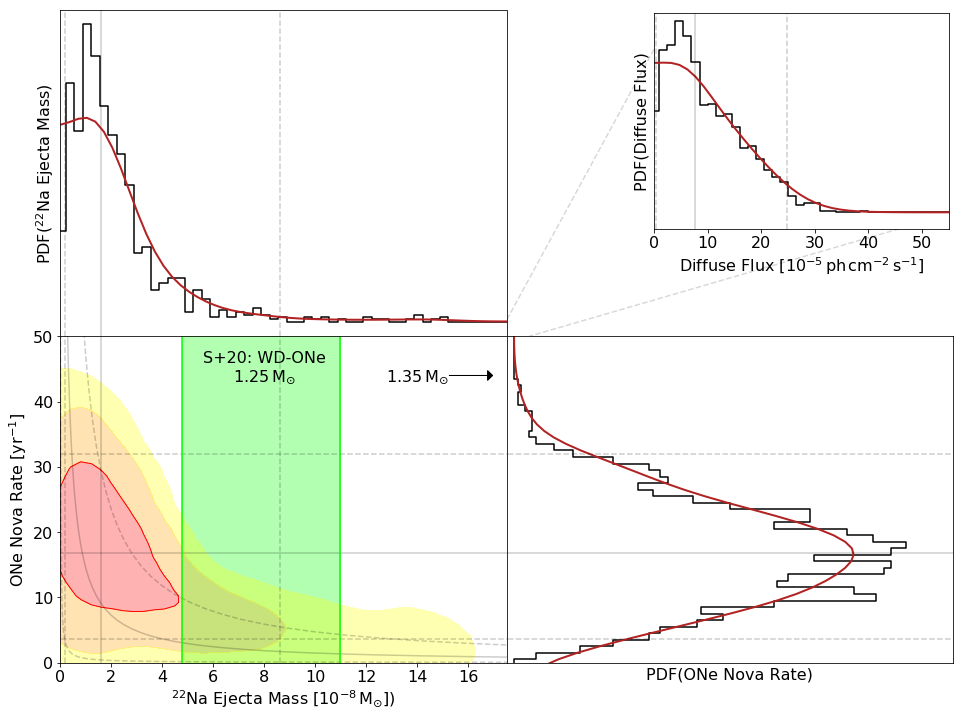

In [526]:
# figure setup
fig, axes = plt.subplots(figsize=(16,12),nrows=2,ncols=2)

# no whitespace between panels
plt.subplots_adjust(hspace=0,wspace=0)

# [1,0] os bottom left
axes[1,0].contourf(xbins, ybins, sigma, levels=[0,0.683,0.954,0.997], colors=('red','orange','yellow'), alpha=.3)
cc = axes[1,0].contour(xbins, ybins, sigma, levels=[0,0.683], colors='red', linewidths=1)

axes[1,0].plot(lgM_arr,flux_bounds_tmp[0]/527.7/lgM_arr*1e8,color='black',linestyle='--',alpha=0.2)
axes[1,0].plot(lgM_arr,flux_bounds_tmp[1]/527.7/lgM_arr*1e8,color='black',linestyle='-',alpha=0.2)
axes[1,0].plot(lgM_arr,flux_bounds_tmp[2]/527.7/lgM_arr*1e8,color='black',linestyle='--',alpha=0.2)

axes[1,0].plot(lgM_arr,np.repeat(rcn_bounds_tmp[0],len(lgM_arr)),color='black',linestyle='--',alpha=0.2)
axes[1,0].plot(lgM_arr,np.repeat(rcn_bounds_tmp[1],len(lgM_arr)),color='black',linestyle='-',alpha=0.2)
axes[1,0].plot(lgM_arr,np.repeat(rcn_bounds_tmp[2],len(lgM_arr)),color='black',linestyle='--',alpha=0.2)

axes[1,0].plot(np.repeat(mass_bounds_tmp[0],2),[0,50],color='black',linestyle='--',alpha=0.2)
axes[1,0].plot(np.repeat(mass_bounds_tmp[1],2),[0,50],color='black',linestyle='-',alpha=0.2)
axes[1,0].plot(np.repeat(mass_bounds_tmp[2],2),[0,50],color='black',linestyle='--',alpha=0.2)

axes[1,0].set_ylim(0.0,50)
axes[1,0].set_xlim(0,17.5)
axes[1,0].set_xlabel(r'$^{22}\mathrm{Na}$ Ejecta Mass [$10^{-8}\,\mathrm{M_{\odot}}$])')
axes[1,0].set_ylabel(r'ONe Nova Rate [$\mathrm{yr^{-1}}$]')

# [0,0] is top left
axes[0,0].set_yticks([])
axes[0,0].set_xticks([])
axes[0,0].set_xlim(0,17.5)
axes[0,0].set_ylim(-0.01972, 0.41408)
axes[0,0].set_ylabel(r'PDF($^{22}\mathrm{Na}$ Ejecta Mass)')
#hist_lgM = np.histogram(lgM_tmp[:,0],bins=np.arange(-9.6,-5.9,0.05),density=True)
#axes[0,0].step(hist_lgM[1][0:-1]+0.025,hist_lgM[0],color='black',where='mid',)
#axes[0,0].plot(hist_lgM[1][0:-1]+0.025,smooth(hist_lgM[0],3),color='firebrick',linewidth=2)
axes[0,0].plot(np.repeat(mass_bounds_tmp[0],2),[-0.01972, 0.41408],color='black',linestyle='--',alpha=0.2)
axes[0,0].plot(np.repeat(mass_bounds_tmp[1],2),[-0.01972, 0.41408],color='black',linestyle='-',alpha=0.2)
axes[0,0].plot(np.repeat(mass_bounds_tmp[2],2),[-0.01972, 0.41408],color='black',linestyle='--',alpha=0.2)
hist_lgM = np.histogram(10**lgM_tmp[:,0]*1e8,bins=np.arange(-0.125,20,1/3),density=True)
axes[0,0].step(hist_lgM[1][0:-1]+1/6,hist_lgM[0],color='black',where='mid',)
axes[0,0].plot(hist_lgM[1][0:-1]+1/6,smooth(hist_lgM[0],3),color='firebrick',linewidth=2)

# top right (erased, but with inlet)
axes[0,1].set_yticks([])
axes[0,1].set_xticks([])
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)
# "subtracting" the prior
hist_flux = np.histogram(np.abs(flux_tmp[:,0]-F_conti_set),bins=np.arange(-0.75,60,1.5),density=True)
axin01 = axes[0,1].inset_axes([0.33, 0.33, 0.66, 0.66])
axin01.step(hist_flux[1][0:-1]+1,hist_flux[0],color='black',where='mid',)
axin01.plot(hist_flux[1][0:-1]+1,smooth(hist_flux[0],3),color='firebrick',linewidth=2)
axin01.set_xlabel(r'Diffuse Flux [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
axin01.set_ylabel(r'PDF(Diffuse Flux)')
axin01.set_yticks([])
axin01.plot(np.repeat(flux_bounds_tmp[0]*1e5,2),[-0.0061237, 0.07432335],color='black',linestyle='--',alpha=0.2)
axin01.plot(np.repeat(flux_bounds_tmp[1]*1e5,2),[-0.0061237, 0.07432335],color='black',linestyle='-',alpha=0.2)
axin01.plot(np.repeat(flux_bounds_tmp[2]*1e5,2),[-0.0061237, 0.07432335],color='black',linestyle='--',alpha=0.2)
axin01.set_ylim(-0.0061237, 0.07432335)
axin01.set_xlim(0,55)
axes[0,1].set_xlim(0,1)
axes[0,1].set_ylim(0,1)
axes[0,1].plot([0.88,0.05],[0.33,0],color='gray',linestyle='--',alpha=0.3)
axes[0,1].plot([0.33,0],[0.88,0.05],color='gray',linestyle='--',alpha=0.3)

# bottom right
axes[1,1].set_yticks([])
axes[1,1].set_xticks([])
axes[1,1].set_xlim(-0.001,0.06)
axes[1,1].set_ylim(0,50)
hist_RCN = np.histogram(R_CN_tmp[:],bins=np.arange(-3,53,1),density=True)
axes[1,1].step(hist_RCN[0],hist_RCN[1][0:-1]+0.5,color='black',where='mid')
axes[1,1].plot(smooth(hist_RCN[0],3),hist_RCN[1][0:-1]+0.5,color='firebrick',linewidth=2)
axes[1,1].plot([-1,1],np.repeat(rcn_bounds_tmp[0],2),color='black',linestyle='--',alpha=0.2)
axes[1,1].plot([-1,1],np.repeat(rcn_bounds_tmp[1],2),color='black',linestyle='-',alpha=0.2)
axes[1,1].plot([-1,1],np.repeat(rcn_bounds_tmp[2],2),color='black',linestyle='--',alpha=0.2)
axes[1,1].set_xlabel(r'PDF(ONe Nova Rate)')

# theory predictions
axes[1,0].axvline(1e8*(M_ej22_S09_125[3]),color='lime')
axes[1,0].axvline(1e8*(M_ej22_S09_125[4]),color='lime')
axes[1,0].fill_between([1e8*(M_ej22_S09_125[3]),1e8*(M_ej22_S09_125[4]),
                      1e8*(M_ej22_S09_125[4]),1e8*(M_ej22_S09_125[3]),
                      1e8*(M_ej22_S09_125[3])],
                        [50,50,0,0,50],
                        color='lime',alpha=0.3,zorder=-1000)
axes[1,0].text(8,45,'S+20: WD-ONe\n'+r'$1.25\,\mathrm{M_{\odot}}$',
        horizontalalignment='center',verticalalignment='center')

axes[1,0].text(14,45,'\n'+r'$1.35\,\mathrm{M_{\odot}}$',
        horizontalalignment='center',verticalalignment='center')
axes[1,0].arrow(15.25,44.,1.5,0,head_width=0.1*15, head_length=0.2, fc='black', ec='black',alpha=1.0)


plt.savefig('Diffuse_Emission_Posteriors_22Na.pdf')

In [527]:
# axin01.get_ylim()
# axes[0,0].get_ylim()

<h3>Values:</h3>

In [528]:
print('Upper bound on diffuse 1.275 MeV flux (x 1e-5 ph/cm2/s): '+\
      str('%.1f' % (np.percentile(flux_tmp[:,0],99.85))+'.'))
print('Upper bound on ejected Na-22 mass from cumulative diffuse model (x 1e-8 Msun): '+\
      str('%.1f' % (np.percentile(10**lgM_tmp[:,0],99.85)*1e8))+'.')

Upper bound on diffuse 1.275 MeV flux (x 1e-5 ph/cm2/s): 39.4.
Upper bound on ejected Na-22 mass from cumulative diffuse model (x 1e-8 Msun): 27.3.


<h3>Actually not too bad: we find that most ONe white dwarfs (assuming all 1.275 MeV emission is from novae, which is almost correct) are not 1.35 Msun heavy. In fact, our limit is right on the edge of what theory predicts for lower-mass ONe WDs.</h3>

<h1>Now the hierarchical model: can we get an even better limit assuming all sources behave about the same?<br>
    <br>
    For this, we would ideally fit that complete model I showed you, but which is not feasible to fit to the raw data. But we have the posterior distributions of the fluxes for each source which means, the information that we want is partly encoded in this (though, there is considerable information loss because it is shrunk to one distribution of 1000 samples (per source), rather than 1.5 million data points).<br>
    We will use these distributions to see if one common value for all is appropriate:</h1>

<h3>Going back to the flux posteriors to see how we can describe the "effect" (mean) and "uncertainty" (width) of these distributions:</h3>

In [529]:
# example: random source in list
with np.load(result_files_final[10]) as content:
    flux_tmp = content['fit_tmp_flux']

<h3>We histogram the flux posterior:</h3>

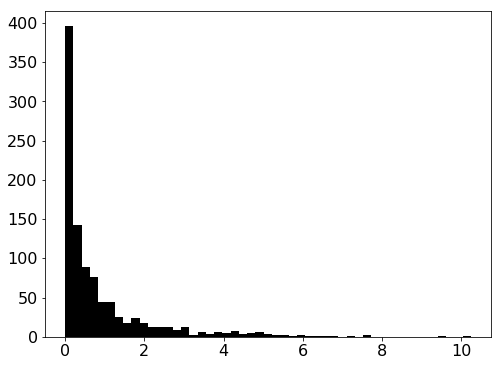

In [530]:
plt.hist(flux_tmp[:,0],bins=np.linspace(0,flux_tmp[:,0].max(),50));

<h3>What distribution is this?<br>
    Well, we fitted one parameter (a rate) to Poisson-distributed data. If you do the math (I won't), you find that the posterior distribution of that rate is similar to a Gamma-distribution. A Gamma-distribution approaches a normal distribution for large mean values, which is not the case here. For small mean values, it is more like an exponential distribution.<br>
    We need to define the "effect size" $\mu$ and its "uncertainty" $\sigma$ from this distribution. It is clearly not symmetric and has a long tail. We will try that by describing each posterior with a $\Gamma$-distribution and get its parameters $\alpha$ and $\beta$, $\Gamma(\alpha,\beta)$.<br>
    Our hierarchical model will not directly predict $\alpha$, but the mean of the $\Gamma$-distribution, $\mu = \alpha/\beta$. But since we know $\beta$ once we did all the fits, we can solve for $\alpha = \mu\beta$, and finally fit our model.</h3>

<h3>Stan model to fit a $\Gamma$-distribution:</h3>

In [531]:
import pystan

In [532]:
p2gfit = \
"""
data {
 int<lower=1> N;     // sample size
 real<lower=0> y[N]; // values
}

parameters {
 real<lower=0> alpha;   // convention such that mean = alpha/beta
 real<lower=0> beta;    // 
}

model {
 for (n in 1:N) {
  y[n] ~ gamma(alpha, beta);
 }
}
"""

<h3>Compile model</h3>

In [124]:
modelg = pystan.StanModel(model_code=p2gfit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7fa0d5f0da1435b1cf5f679d75f6dd1a NOW.


<h3>Data dictionary</h3>

In [533]:
data_tmp = dict(N = len(flux_tmp[:,0]),
                y = flux_tmp[:,0])

<h3>And fit</h3>

In [534]:
fit_tmp = modelg.sampling(data=data_tmp,chains=1,iter=2000)

In [535]:
fit_tmp

Inference for Stan model: anon_model_7fa0d5f0da1435b1cf5f679d75f6dd1a.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.64  1.5e-3   0.03   0.59   0.62   0.64   0.65   0.69    293    1.0
beta    0.73  2.4e-3   0.04   0.65    0.7   0.73   0.76   0.81    319    1.0
lp__  -785.4    0.05   1.11 -788.6 -785.7 -785.1 -784.6 -784.3    452    1.0

Samples were drawn using NUTS at Tue Nov 17 21:10:36 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [536]:
print('Flux mean (x 1e-5 ph/cm2/s): '+str('%.1f' % (fit_tmp['alpha'].mean()/fit_tmp['beta'].mean())))
print('Flux std (x 1e-5 ph/cm2/s):  '+str('%.1f' % (np.sqrt(fit_tmp['alpha'].mean())/fit_tmp['beta'].mean())))

Flux mean (x 1e-5 ph/cm2/s): 0.9
Flux std (x 1e-5 ph/cm2/s):  1.1


<h3>For plotting the Gamma-distribution:</h3>

In [537]:
from scipy.special import gamma as Gamma
def plot_gamma(par,p):
    k = p[0]
    theta = p[1]
    val = par**(k-1)*np.exp(-par/theta)/(theta**k*Gamma(k))
    return val

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


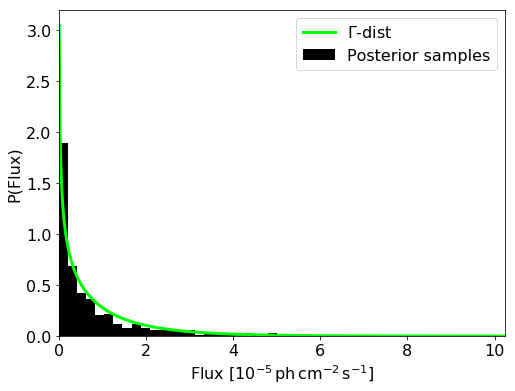

In [538]:
x = np.linspace(0,flux_tmp[:,0].max(),1000)
plt.hist(flux_tmp[:,0],bins=np.linspace(0,flux_tmp[:,0].max(),50),density=True,label='Posterior samples');
plt.plot(x,plot_gamma(x,[fit_tmp['alpha'].mean(),1/fit_tmp['beta'].mean()]),color='lime',linewidth=3,label=r'$\Gamma$-dist')
#plt.yscale('log')
plt.xlim(0,flux_tmp[:,0].max())
plt.xlabel(r'Flux [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylabel(r'P(Flux)')
plt.legend()

<h3>Not too bad. Let's look at all novae to get a feeling for how good/bad this is (and save the results in empty lists). This can take a few minutes.</h3>

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


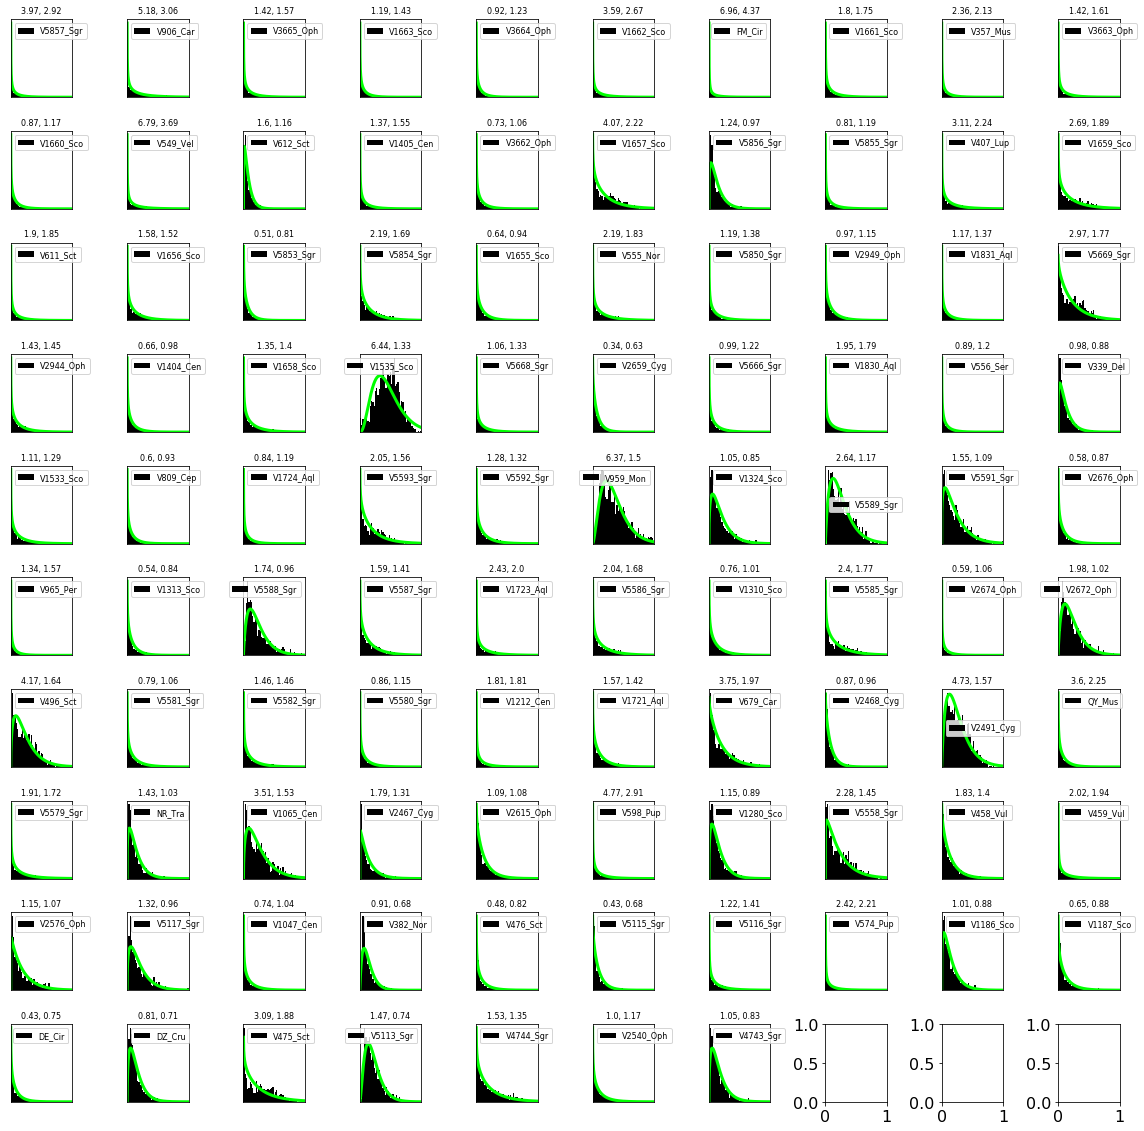

In [539]:
flux_posterior_alpha = []
flux_posterior_beta = []


fig, ax = plt.subplots(10,10,figsize=(16,16))

cnt = 0
for i in tqdm(range(len(result_files_final))):
    with np.load(result_files_final[i]) as content:
        flux_tmp = content['fit_tmp_flux']
        dist_tmp = content['fit_tmp_dist']
        lgM_tmp = content['fit_tmp_lgM']   
        
        
    data_tmp = {"N":len(flux_tmp[:,0]),
                "y":flux_tmp[:,0]}
    
    fit_tmp = modelg.sampling(data=data_tmp,chains=1,iter=1000)
    
    ax_tmp = ax.ravel()[cnt]

    f_max = flux_tmp[:,0].max()
    
    ax_tmp.hist(flux_tmp[:,0],bins=np.linspace(0,f_max,50),density=True,
             label=result_files_final[i].split(results_dir)[1].split('/')[0][4:]);
    
    x = np.linspace(0,f_max,1000)
    
    ax_tmp.plot(x,plot_gamma(x,[fit_tmp['alpha'].mean(),1/fit_tmp['beta'].mean()]),color='lime',linewidth=3)
    ax_tmp.set_title(str(np.round(fit_tmp['alpha'].mean()/fit_tmp['beta'].mean(),2))+', '+\
                     str(np.round(np.sqrt(fit_tmp['beta'].mean())/fit_tmp['beta'].mean(),2)),fontsize=8)
    ax_tmp.set_xlim(0,f_max)
    ax_tmp.legend(fontsize=8)
    
    ax_tmp.set_xticks([])
    ax_tmp.set_yticks([])
    
    flux_posterior_alpha.append(fit_tmp['alpha'].mean())
    flux_posterior_beta.append(fit_tmp['beta'].mean())
    
    cnt += 1
    
plt.tight_layout()

flux_posterior_alpha = np.array(flux_posterior_alpha)
flux_posterior_beta = np.array(flux_posterior_beta)

<h3>Looks quite promising. Now we reduced our complete data set to pairs of values that describe the information. But it's not for normal distributions but for $\Gamma$-distributions.</h3>

<h3>For the diffuse emission, we need an additional prior for the flux that comes from the diffuse continuum emission of the Galaxy, so that $F_{tot}^{22} = F_{continuum}^{22} + F_{novae}^{22}$, where $F_{continuum}^{22} \sim \mathscr{N}(7.6,2.5)$ (https://ui.adsabs.harvard.edu/abs/2020ApJ...889..169W/abstract), and the actual Na-22 flux from novae is reduced (see above).</h3>

In [540]:
p2gfit_diff_na22 = \
"""
data {
 int<lower=1> N;              // Sample size
 real<lower=0> y[N];         // Outcome
}

parameters {
 real<lower=0> F_conti;
 real<lower=0> F_0;   // mean flux
 real<lower=0> F_err; // flux uncertainty
}

model {
 F_conti ~ normal(7.6,2.5);
 y ~ gamma((F_0+F_conti)*F_err, F_err); // fit for mean
}

"""

In [216]:
modelg_diff_na22 = pystan.StanModel(model_code=p2gfit_diff_na22)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_834ce63207319de9635741bbe6574e0a NOW.


In [541]:
with np.load(results_dir+'000_Diffuse_Emission/save_StanFit_mass_NovaDiffuse_Emission_final.npz') as content:
    flux_tmp = content['fit_tmp_flux']

In [542]:
data_diff_na22 = dict(N = len(flux_tmp[:,0]),
                      #y = np.abs(flux_tmp[:,0]-F_conti_set),
                      y = flux_tmp[:,0])

In [543]:
fit_tmp = modelg_diff_na22.sampling(data=data_diff_na22,chains=1,iter=5000)
#fit_tmp = modelg.sampling(data=data_diff_na22,chains=1,iter=5000) # if prior "subtracted", which shouldn't be done

In [544]:
fit_tmp

Inference for Stan model: anon_model_834ce63207319de9635741bbe6574e0a.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
F_conti    7.6    0.08    2.4   2.83   6.01    7.6   9.23  12.24    923    1.0
F_0       7.53    0.08   2.42   2.86   5.93   7.53   9.15  12.49    928    1.0
F_err     0.14  2.3e-4 6.5e-3   0.13   0.13   0.14   0.14   0.15    797    1.0
lp__     -3587    0.05   1.36  -3590  -3587  -3586  -3586  -3585    705    1.0

Samples were drawn using NUTS at Tue Nov 17 21:12:41 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Text(0, 0.5, 'P(Flux)')

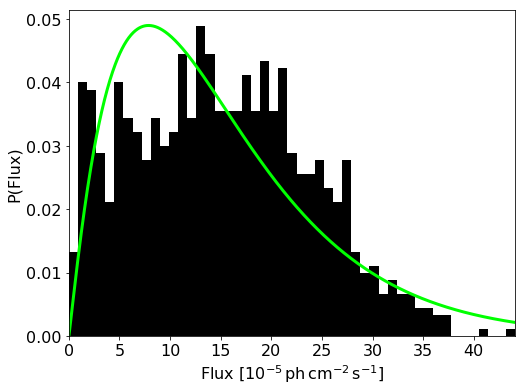

In [545]:
x = np.linspace(0,flux_tmp[:,0].max(),1000)
#plt.hist(np.abs(flux_tmp[:,0]-F_conti_set),bins=np.linspace(0,flux_tmp[:,0].max(),50),density=True);
plt.hist(flux_tmp[:,0],bins=np.linspace(0,flux_tmp[:,0].max(),50),density=True);
#plt.plot(x,plot_gamma(x,[fit_tmp['alpha'].mean(),1/fit_tmp['beta'].mean()]),color='lime',linewidth=3)
plt.plot(x,plot_gamma(x,[(fit_tmp['F_0'].mean()+fit_tmp['F_conti'].mean())*fit_tmp['F_err'].mean(),
                         1/fit_tmp['F_err'].mean()]),color='lime',linewidth=3)
#plt.yscale('log')
plt.xlim(0,flux_tmp[:,0].max())
plt.xlabel(r'Flux [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylabel(r'P(Flux)')


<h3>Not optimal but gives an appropriate tail.</h3>

In [546]:
# upper limit if "subtracted"
np.percentile(np.abs(flux_tmp[:,0]-F_conti_set),99.85)

32.74932619240652

<h3>And if we include the gamma-dsitribution to calculate the upper bound:</h3>

In [547]:
from scipy.stats import gamma

In [548]:
#gamma.ppf(0.5+0.9973/2,fit_tmp['alpha'].mean(),scale=1/fit_tmp['beta'].mean())
gamma.ppf(0.9985,fit_tmp['F_0'].mean()*fit_tmp['F_err'].mean(),scale=1/fit_tmp['F_err'].mean())

47.84278464135908

<h3>somewhat higher than highest sampled point: conservative limit</h3>

In [549]:
# mean
#gamma.mean(fit_tmp['alpha'].mean(),scale=1/fit_tmp['beta'].mean())
gamma.mean(fit_tmp['F_0'].mean()*fit_tmp['F_err'].mean(),scale=1/fit_tmp['F_err'].mean())

7.526682421487551

In [550]:
# std
#gamma.std(fit_tmp['alpha'].mean(),scale=1/fit_tmp['beta'].mean())
gamma.std(fit_tmp['F_0'].mean()*fit_tmp['F_err'].mean(),scale=1/fit_tmp['F_err'].mean())

7.385868636351379

<h3>As expected from the shape of the distribution, we don't "see" diffuse Na-22, as mean ~ std. What's actually happening in gamma.ppf?<br>
    gamma.ppf is the inverse function of the cumulative distribution function (the quartile function):</h3>

In [551]:
from scipy.integrate import quad

In [552]:
quad(plot_gamma,0,47.72,args=([fit_tmp['F_0'].mean()*fit_tmp['F_err'].mean(),1/fit_tmp['F_err'].mean()]))

(0.9984745045695201, 4.46620518346208e-12)

<h3>i.e. $\int_{0}^{47.72}\,dx\,\Gamma(x;\mu\beta,\beta) = 0.9985$, where 47.72 is the solution from the ppf above. The upper bound on the diffuse Na-22 flux would therefore be $\sim 4.8 \times 10^{-4}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$ in the worst case (the limit is probably lower, somehwere between 3 and 4e-4).</h3>

In [553]:
fit_tmp['F_0'].mean()*fit_tmp['F_err'].mean(),fit_tmp['F_err'].mean()

(1.038494081200196, 0.1379750098443706)

<h3>We extend the array by the solution from the diffuse emission:</h3>

In [554]:
flux_posterior_alpha_all = np.concatenate([flux_posterior_alpha,np.array([1.035135116340756])])
flux_posterior_beta_all = np.concatenate([flux_posterior_beta,np.array([0.13814676716114208])])

<h3>Comparison between gamma-distribution limits (i.e. the approximation) and the "real" limits from the SPI fits:</h3>

TypeError: 'tuple' object is not callable

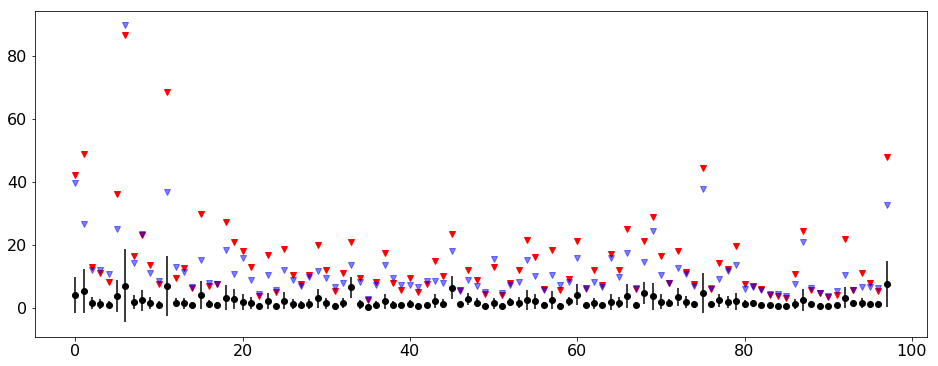

In [555]:
plt.figure(figsize=(16,6))
plt.errorbar(np.arange(len(flux_posterior_alpha_all)),flux_posterior_alpha_all/flux_posterior_beta_all,
            yerr=np.sqrt(flux_posterior_alpha_all)/flux_posterior_beta_all,marker='o',linestyle='',
            label='mean+std')
plt.plot(np.arange(len(flux_posterior_alpha_all)),
         gamma.ppf(0.9985,flux_posterior_alpha_all,scale=1/flux_posterior_beta_all),'v',
         label=r'$\Gamma$-approximation upper bound')
plt.plot(np.arange(len(flux_posterior_alpha_all)-1),flux_limits/1e-5,'v',alpha=0.5,label='sampled upper bound')
plt.plot(np.arange(len(flux_posterior_alpha_all))[-1],np.percentile(np.abs(flux_tmp[:,0]-F_conti_set),99.85),
         'v',color='blue',alpha=0.5)
plt.ylim(1e-1,1e2)
plt.legend()
plt.xlabel('Object ID')
plt.ylabel(r'1.275 MeV Flux $10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$')
plt.yscale('log')

<h3>So, on average, the $\Gamma$-approsimation gives higher bounds; again, this means we will have a conservative estimate for the hierarchical model in the end.</h3>

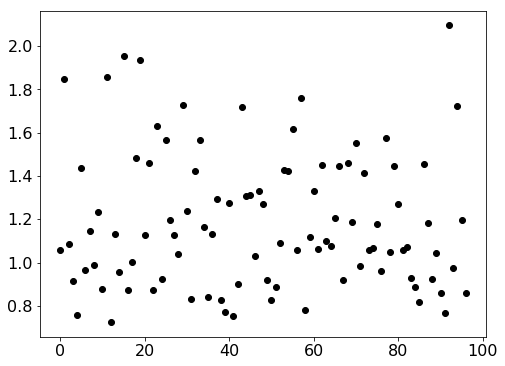

In [556]:
plt.plot(np.arange(len(flux_posterior_alpha_all)-1),
         gamma.ppf(0.9985,flux_posterior_alpha_all,scale=1/flux_posterior_beta_all)[0:-1]/(flux_limits/1e-5),'o')

<h1>Test: hierarchical model for the <em>flux</em>. This doesn't necesarily makes sence, but we can just assume it to see the differences in the model structure:</h1>

<h3>No Pooling:</h3>

In [557]:
na22_no_pooling_test =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;        // mean flux values
    //vector[N] flux_stds = sqrt(fluxes_alpha) ./ fluxes_beta; // std (not needed)
}

parameters {
    real<lower=0> theta[N]; // one fit parameter for each source
}

model {
    
    for (n in 1:N) {
        flux_means[n] ~ gamma(theta[n]*fluxes_beta[n], fluxes_beta[n]);
    }
    
    
}

"""

In [372]:
model_np_test = pystan.StanModel(model_code=na22_no_pooling_test)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b9042b736931014a9fae2333029706ab NOW.


In [558]:
data_np = dict(N            = len(flux_posterior_alpha_all),
               fluxes_alpha = flux_posterior_alpha_all,
               fluxes_beta  = flux_posterior_beta_all)

In [559]:
fit_np = model_np_test.sampling(data=data_np,chains=10,iter=20000)
# reduce the iterations or chains if it takes too long

In [560]:
print(fit_np.stansummary(['theta','lp__'],probs=[0.0015,0.5,0.9985]))

Inference for Stan model: anon_model_b9042b736931014a9fae2333029706ab.
10 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=100000.

            mean se_mean     sd  0.15%    50% 99.85%  n_eff   Rhat
theta[1]   11.19    0.01   6.57   0.46   10.1  38.65 193241    1.0
theta[2]   13.35    0.02   7.74   0.49  12.09  45.12 203106    1.0
theta[3]    3.57  4.6e-3   2.06   0.13   3.23  11.87 199951    1.0
theta[4]    2.98  3.9e-3   1.72   0.12   2.69   9.92 194873    1.0
theta[5]    2.26  2.9e-3    1.3    0.1   2.06   7.52 195053    1.0
theta[6]    9.73    0.01   5.65   0.39   8.81  33.01 189565    1.0
theta[7]   22.52    0.03  13.54   0.83  20.18  79.38 198879    1.0
theta[8]    4.47  5.9e-3   2.58   0.19   4.06  14.99 192713    1.0
theta[9]    6.26  8.3e-3   3.69   0.23   5.64  21.77 195185    1.0
theta[10]   3.66  4.7e-3   2.12   0.14   3.32  12.35 199966    1.0
theta[11]    2.1  2.7e-3    1.2   0.09   1.91   6.98 200323    1.0
t

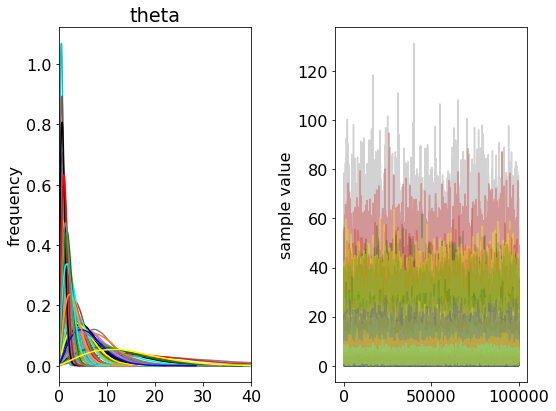

In [561]:
aa = fit_np.plot();
aa.axes[0].set_xlim(0,40)
plt.tight_layout();

Text(0, 0.5, '1.275 MeV Flux $10^{-5}\\,\\mathrm{ph\\,cm^{-2}\\,s^{-1}}$')

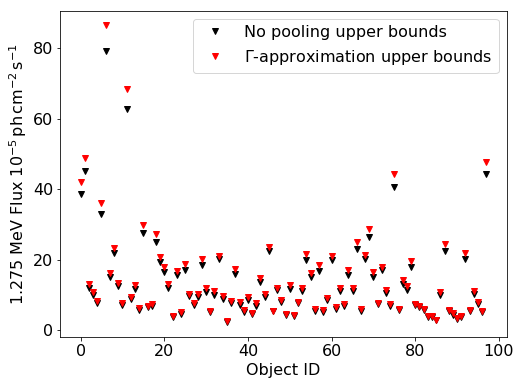

In [562]:
plt.plot(np.arange(len(flux_posterior_alpha_all)),np.percentile(fit_np['theta'],99.85,axis=0),'v',\
         label='No pooling upper bounds')
plt.plot(np.arange(len(flux_posterior_alpha_all)),
         gamma.ppf(0.9985,flux_posterior_alpha_all,scale=1/flux_posterior_beta_all),'v',
         label=r'$\Gamma$-approximation upper bounds')
plt.legend()
plt.xlabel('Object ID')
plt.ylabel(r'1.275 MeV Flux $10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$')

<h3>What did we do? - Actually nothing: No pooling means, every value for its own, so we described 98 gamma-distributions with 98 gamma-distributions.</h3>

<h3>Complete Pooling:</h3>

In [564]:
na22_complete_pooling_test =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;        // mean flux values
    //vector[N] flux_stds = sqrt(fluxes_alpha) ./ fluxes_beta; // std (not needed)
}

parameters {
    real<lower=0> theta; // one fit parameter for all sources
}

model {
    
    for (n in 1:N) {
        flux_means[n] ~ gamma(theta*fluxes_beta[n], fluxes_beta[n]);
    }
    
    
}

"""

In [394]:
model_cp_test = pystan.StanModel(model_code=na22_complete_pooling_test)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7aba9b9404220e99a36fde1e5a3ea2a5 NOW.


In [565]:
fit_cp = model_cp_test.sampling(data=data_np,chains=10,iter=20000)

In [566]:
print(fit_cp.stansummary(['theta','lp__'],probs=[0.0015,0.5,0.9985]))

Inference for Stan model: anon_model_7aba9b9404220e99a36fde1e5a3ea2a5.
10 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=100000.

        mean se_mean     sd  0.15%    50% 99.85%  n_eff   Rhat
theta   1.71  6.7e-4   0.13   1.35   1.71    2.1  35135    1.0
lp__  -82.38  3.2e-3   0.71 -86.93  -82.1 -81.88  48744    1.0

Samples were drawn using NUTS at Tue Nov 17 21:14:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


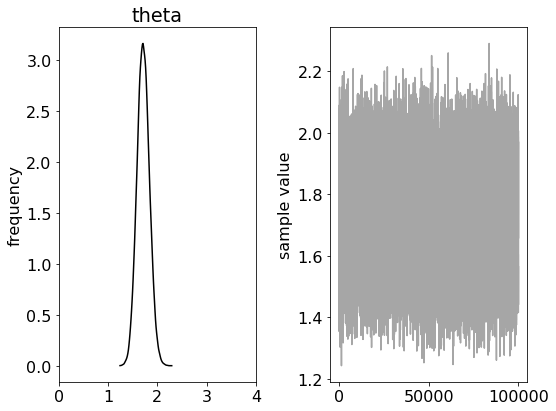

In [567]:
bb = fit_cp.plot();
bb.axes[0].set_xlim(0,4)
plt.tight_layout();

TypeError: 'tuple' object is not callable

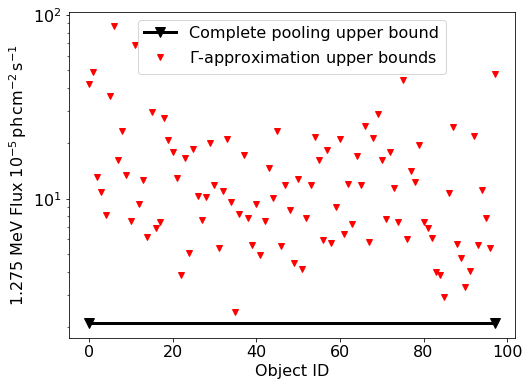

In [568]:
plt.plot([0,97],np.repeat(np.percentile(fit_cp['theta'],99.85),2),'v-',
         label='Complete pooling upper bound',markersize=10,linewidth=3)
plt.plot(np.arange(len(flux_posterior_alpha_all)),
         gamma.ppf(0.9985,flux_posterior_alpha_all,scale=1/flux_posterior_beta_all),'v',
         label=r'$\Gamma$-approximation upper bounds')

plt.legend()
plt.xlabel('Object ID')
plt.ylabel(r'1.275 MeV Flux $10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$')
plt.yscale('log')
plt.ylim(1e-1,)

In [569]:
np.percentile(fit_cp['theta'],99.85),flux_limits.min()/1e-5,gamma.ppf(0.9985,flux_posterior_alpha_all,scale=1/flux_posterior_beta_all).min()

(2.1011981122815757, 2.8760743511556974, 2.414631687665602)

<h3>Assuming <em>the same flux(!) expectation</em> for each source, a common upper bound would in fact be smaller than any single value. Of course, it is dominated by the smallest value; though, here we get an improvement of ~15%.<br>
    Remember that fitting for the flux is nonsense and just to show what's the difference.</h3>

<h3>Partial Pooling:</h3>

In [570]:
na22_partial_pooling_test =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;        // mean flux values
    //vector[N] flux_stds = sqrt(fluxes_alpha) ./ fluxes_beta; // std (not needed)
}

parameters {
    real<lower=0> mu;  // mean of hyperdistribution
    real<lower=0> tau; // std of hyperdistribution
    vector[N] eta;     // helper variable
}

transformed parameters {
    vector<lower=0>[N] theta;           // effect size for each object (same as before)
    theta = mu + tau * eta;;
    //for (n in 1:N) {
    //    theta[n] = abs(mu + tau * eta[n]);    // normal distribution for theta
    //}
}

model {
    eta ~ normal(0, 1);
    tau ~ uniform(0,10);
    mu ~ uniform(0,10);
    for (n in 1:N) {
        flux_means[n] ~ gamma(theta[n]*fluxes_beta[n], fluxes_beta[n]);
    }
}

"""

In [441]:
model_pp_test = pystan.StanModel(model_code=na22_partial_pooling_test)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6efcce5a8e0ee6fff21d9091c103703b NOW.


In [571]:
# there will pop up several 1000 warnings, but that's not to worry, we wont predict negative fluxes later
fit_pp = model_pp_test.sampling(data=data_np,chains=10,iter=20000,control={'adapt_delta':0.95})

In [572]:
print(fit_pp.stansummary(['mu','tau','theta','lp__'],probs=[0.0015,0.5,0.9985]))

Inference for Stan model: anon_model_6efcce5a8e0ee6fff21d9091c103703b.
10 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=100000.

            mean se_mean     sd  0.15%    50% 99.85%  n_eff   Rhat
mu          1.75  3.9e-4   0.14   1.38   1.75    2.2 120200    1.0
tau          0.2  6.5e-4   0.14 5.4e-4   0.18   0.71  47325    1.0
theta[1]    1.78  8.4e-4   0.28   0.87   1.75   3.13 115655    1.0
theta[2]    1.79  8.6e-4   0.29   0.88   1.76   3.13 111304    1.0
theta[3]    1.77  7.9e-4   0.28   0.84   1.75   3.04 121289    1.0
theta[4]    1.76  7.8e-4   0.27   0.81   1.74   3.02 125553    1.0
theta[5]    1.75  7.5e-4   0.27   0.81   1.73   2.93 129911    1.0
theta[6]    1.78  8.4e-4   0.28   0.87   1.75   3.12 113616    1.0
theta[7]    1.79  8.9e-4   0.29   0.88   1.76   3.14 104717    1.0
theta[8]    1.77  8.3e-4   0.28   0.85   1.75   3.08 113664    1.0
theta[9]    1.78  8.4e-4   0.28   0.88   1.75   3.11 113688    1.0
t

(0.01, 10)

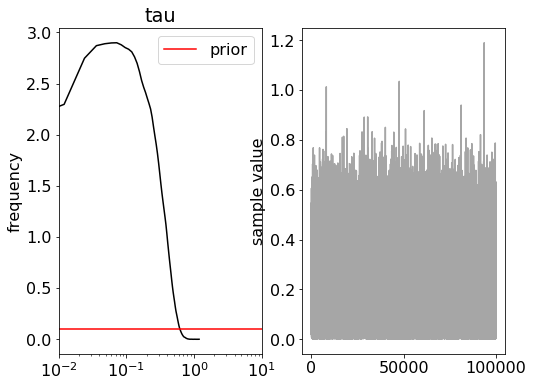

In [573]:
cc = fit_pp.plot('tau');
cc.axes[0].plot([0,10],[0.1,0.1],color='red',label='prior')
cc.axes[0].legend()
cc.axes[0].set_xscale('log')
cc.axes[0].set_xlim(1e-2,10)

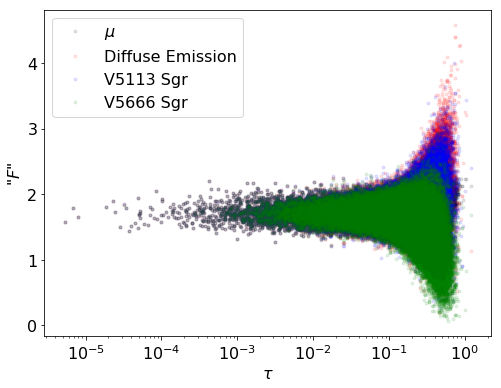

In [575]:
plt.plot(fit_pp['tau'],fit_pp['mu'],'.',alpha=0.1,label=r'$\mu$')
plt.plot(fit_pp['tau'],fit_pp['theta[98]'],'.',alpha=0.1,label=r'Diffuse Emission')
plt.plot(fit_pp['tau'],fit_pp['theta[94]'],'.',alpha=0.1,label=r'V5113 Sgr')
plt.plot(fit_pp['tau'],fit_pp['theta[36]'],'.',alpha=0.1,label=r'V5666 Sgr')
plt.xlabel(r'$\tau$')
plt.ylabel(r'"$F$"')
plt.legend()
plt.xscale('log')

<h3>What's going on: Depending on how much scatter we allow (the larger $\tau$, the larger the scatter), the flux values go toward their own mean values. Higher $\tau$ values than ~1 are not favoured in this fit, which means, everything is more consistent with one common value.<br>
    (This even makes sense for the flux case because the sources have almost an intrinsic limit to the flux which is described by how long we long and see nothing.)<br>
We also see the funnel if we plot $\tau$ in log-scale. Apparently everything is working.<br>
Note that for large $\tau$, the individual values are not significant any more as expected from the single fits.</h3>

<h1>Now the real thing with mass:</h1>

In [576]:
na22_no_pooling_srcs =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
 
    // ejected mass
    real mu_lgM;                   // prior for the log mass of ALL objects
    real sigma_lgM;                // width of log mass prior
    real lgM_min;                  // lower bound of sampling region of lgM (to avoid uninteresting regions)
 
    // if distance is not known, use global distrribution, approximated by gamma distribution with fixed parameters
    real distance_alpha[N-1];      // gamma distribution alpha parameter for distance; or mean of normal distribution
    real distance_beta[N-1];       // gamma distribution beta parameters (=1/theta) for distance; or width of normal distribution
    int known_dist_idx[N];         // index for objects with known distance (diffuse distance known)
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;         // flux means
    // vector[N] flux_stds = sqrt(fluxes_alpha) ./ fluxes_beta; // not needed
    
    print(flux_means); // cross check
}

parameters {
    real<lower=lgM_min,upper=-4> lgM[N];  // mass for each object
    real<lower=0.1,upper=40.0> dist[N-1]; // distance for each object
    real<lower=1.,upper=150.> R_CN;       // nota rate for diffuse emission
}


transformed parameters {

    real flux[N]; // calculate flux

    for (n in 1:N) {

        if (known_dist_idx[n] < 2) { // flag for point source (0 or 1) or diffuse (2)

            flux[n] = exp(19.765621 + 2.3026*lgM[n] - 2*log(dist[n]));

        } else {

            flux[n] = exp(17.781483 + 2.3026*lgM[n] + log(R_CN));

        }

    }

}


model {
    
    lgM ~ normal(mu_lgM,sigma_lgM);                              // normal prior(s) for log mass

    for (n in 1:N-1) { // loop over objects

        if (known_dist_idx[n] == 1) { // if distance known, use gaussian prior

            dist[n] ~ normal(distance_alpha[n],distance_beta[n]);

        } else { // if not generic gamma prior

            dist[n] ~ gamma(4.25,0.408);                        // gamma prior(s) for the dist

        }

    }

    # Shafter+2017 nova rate 50+25/yr for CO novae (~1/3 for ONe novae, there fore use 17+-8)
    R_CN ~ normal(50./3,25./3); // ONe nova rate
    
    
    
    for (n in 1:N) {
        flux_means[n] ~ gamma(flux[n]*fluxes_beta[n], fluxes_beta[n]);
    }
    
}

"""

In [471]:
model_np_lgm = pystan.StanModel(model_code=na22_no_pooling_srcs)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_36c5cfaf8e2716f24da309275f23c03c NOW.


<h3>We need the additional information from our catalogue to include in the data for the fit:</h3>

In [577]:
use_novae = [4]+list(np.concatenate([np.arange(6,103)]))

N_use = len(use_novae)

known_dist_idx = np.zeros(N_use)
for i in range(N_use):

    print('| Source index: '+str(use_novae[i]))
    if (i != N_use-1):
        print('| Source name: '+str(names[use_novae[i]]))
    else:
        print('| Source name: Diffuse')

    if (i != N_use-1):

        T0_tmp = data_frame['IJD'][good_novae].values[use_novae[i]]
        print('| Explosion date [IJD]: '+str(T0_tmp))

        # check which model to load
        if dist[use_novae[i]] == unknown_dist:
            print('| Distance to source is NOT known, using generic gamma prior ...')
        else:
            print('| Distance to source is known: %.1f +- %.1f kpc; using normal prior ...' % (dist[use_novae[i]],dist_err[use_novae[i]]))
            known_dist_idx[i] = 1

    else:

        # diffuse emission model
        print('| Diffuse emission model ...')

        known_dist_idx[i] = 2

dist_arr     = dist[use_novae[0:-1]]
dist_arr_err = dist_err[use_novae[0:-1]]

| Source index: 4
| Source name: V5857 Sgr
| Explosion date [IJD]: 6672.7229976851895
| Distance to source is NOT known, using generic gamma prior ...
| Source index: 6
| Source name: V906 Car
| Explosion date [IJD]: 6653.32
| Distance to source is NOT known, using generic gamma prior ...
| Source index: 7
| Source name: V3665 Oph
| Explosion date [IJD]: 6643.805
| Distance to source is NOT known, using generic gamma prior ...
| Source index: 8
| Source name: V1663 Sco
| Explosion date [IJD]: 6629.3600000000015
| Distance to source is NOT known, using generic gamma prior ...
| Source index: 9
| Source name: V3664 Oph
| Explosion date [IJD]: 6617.834004629629
| Distance to source is NOT known, using generic gamma prior ...
| Source index: 10
| Source name: V1662 Sco
| Explosion date [IJD]: 6611.862997685188
| Distance to source is NOT known, using generic gamma prior ...
| Source index: 11
| Source name: FM Cir
| Explosion date [IJD]: 6593.707997685182
| Distance to source is NOT known,

In [582]:
data   = dict(N               = len(flux_posterior_alpha_all),
              fluxes_alpha    = flux_posterior_alpha_all,
              fluxes_beta     = flux_posterior_beta_all,
              mu_lgM          = -10,
              sigma_lgM       = 100, # basically leave everything unconstrained
              lgM_min         = -20, # we use a very low limit to not disturb anything
              distance_alpha  = dist_arr,
              distance_beta   = dist_arr_err,
              known_dist_idx  = known_dist_idx.astype(int))

In [583]:
fit_np_lgm = model_np_lgm.sampling(data=data,chains=10,iter=20000)

In [584]:
print(fit_np_lgm.stansummary(['lgM','flux','lp__'],probs=[0.0015,0.5,0.9985]))

Inference for Stan model: anon_model_36c5cfaf8e2716f24da309275f23c03c.
10 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=100000.

           mean se_mean     sd  0.15%    50% 99.85%  n_eff   Rhat
lgM[1]    -6.03  2.1e-3   0.67  -8.77  -5.96  -4.51 105783    1.0
lgM[2]    -5.94  2.1e-3   0.67  -8.69  -5.87  -4.44 103240    1.0
lgM[3]    -6.51  2.2e-3   0.67  -9.32  -6.44  -4.99  95922    1.0
lgM[4]    -6.59  2.1e-3   0.66  -9.28  -6.52  -5.08  98121    1.0
lgM[5]    -6.71  2.2e-3   0.66  -9.44  -6.64  -5.22  93076    1.0
lgM[6]    -6.09  2.1e-3   0.67  -8.83  -6.02  -4.59 104701    1.0
lgM[7]    -5.75  2.0e-3   0.68  -8.57  -5.68  -4.22 111767    1.0
lgM[8]    -6.42  2.2e-3   0.67  -9.21  -6.35   -4.9  95065    1.0
lgM[9]    -6.28  2.1e-3   0.67  -9.05  -6.21  -4.76  98095    1.0
lgM[10]   -6.51  2.1e-3   0.67  -9.25  -6.44   -5.0  98376    1.0
lgM[11]   -6.74  2.1e-3   0.66  -9.43  -6.67  -5.23  95116    1.0
lgM[12]   -5.

<h3>Again, only each source on its own. Let's compare the upper bounds from this to the bounds from the individual SPI fits:</h3>

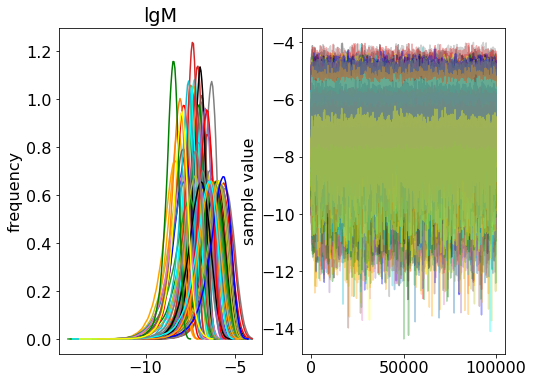

In [585]:
dd = fit_np_lgm.plot(['lgM'])

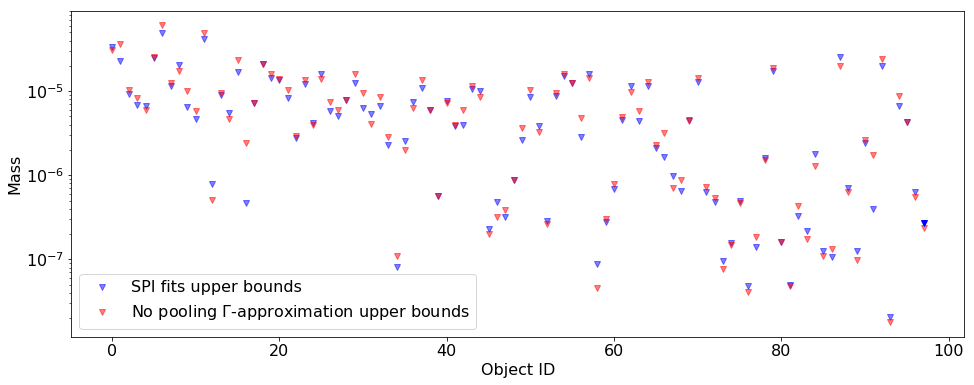

In [595]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(len(flux_posterior_alpha_all))[0:-1],mass_limits,'bv',\
         label='SPI fits upper bounds',alpha=0.5)
plt.plot(np.arange(len(flux_posterior_alpha_all)),
         10**np.percentile(fit_np_lgm['lgM'],99.85,axis=0),'rv',
         label=r'No pooling $\Gamma$-approximation upper bounds',alpha=0.5)
plt.plot(97,27.3e-8,'bv')
plt.legend()
plt.xlabel('Object ID')
plt.ylabel(r'Mass')
plt.yscale('log')

<h3>As expected, no strong deviations. Good.</h3>

<h3>Complete Pooling Masses:</h3>

In [596]:
na22_complete_pooling_srcs =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
 
    // ejected mass
    real mu_lgM;                   // prior for the log mass of ALL objects
    real sigma_lgM;                // width of log mass prior
    real lgM_min;                  // lower bound of sampling region of lgM (to avoid uninteresting regions)
 
    // if distance is not known, use global distrribution, approximated by gamma distribution with fixed parameters
    real distance_alpha[N-1];      // gamma distribution alpha parameter for distance; or mean of normal distribution
    real distance_beta[N-1];       // gamma distribution beta parameters (=1/theta) for distance; or width of normal distribution
    int known_dist_idx[N];         // index for objects with known distance (diffuse distance known)
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;         // flux means
    // vector[N] flux_stds = sqrt(fluxes_alpha) ./ fluxes_beta; // not needed
    
    print(flux_means); // cross check
}

parameters {
    real<lower=lgM_min,upper=-4> lgM   ;  // mass for ALL objects
    real<lower=0.1,upper=40.0> dist[N-1]; // distance for each object
    real<lower=1.,upper=150.> R_CN;       // nota rate for diffuse emission
}


transformed parameters {

    real flux[N]; // calculate flux

    for (n in 1:N) {

        if (known_dist_idx[n] < 2) { // flag for point source (0 or 1) or diffuse (2)

            flux[n] = exp(19.765621 + 2.3026*lgM - 2*log(dist[n]));

        } else {

            flux[n] = exp(17.781483 + 2.3026*lgM + log(R_CN));

        }

    }

}


model {
    
    lgM ~ normal(mu_lgM,sigma_lgM);                              // normal prior for log mass

    for (n in 1:N-1) { // loop over objects

        if (known_dist_idx[n] == 1) { // if distance known, use gaussian prior

            dist[n] ~ normal(distance_alpha[n],distance_beta[n]);

        } else { // if not generic gamma prior

            dist[n] ~ gamma(4.25,0.408);                        // gamma prior(s) for the dist

        }

    }

    # Shafter+2017 nova rate 50+25/yr for CO novae (~1/3 for ONe novae, there fore use 17+-8)
    R_CN ~ normal(50./3,25./3); // ONe nova rate
    
    
    
    for (n in 1:N) {
        flux_means[n] ~ gamma(flux[n]*fluxes_beta[n], fluxes_beta[n]);
    }
    
}

"""

In [597]:
model_cp_lgm = pystan.StanModel(model_code=na22_complete_pooling_srcs)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_757056e359f31d2aa582b7ca5a19a6bc NOW.


In [598]:
fit_cp_lgm = model_cp_lgm.sampling(data=data,chains=10,iter=20000)

In [599]:
print(fit_cp_lgm.stansummary(['lgM','flux','lp__'],probs=[0.0015,0.5,0.9985]))

Inference for Stan model: anon_model_757056e359f31d2aa582b7ca5a19a6bc.
10 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=100000.

           mean se_mean     sd  0.15%    50% 99.85%  n_eff   Rhat
lgM       -7.27  1.6e-4   0.05  -7.42  -7.27  -7.13  86050    1.0
flux[1]    1.44  6.3e-3    2.0   0.04   0.73  16.14  99205    1.0
flux[2]    1.59  7.5e-3    2.3   0.04   0.77  18.47  93250    1.0
flux[3]    0.89  2.5e-3   0.91   0.04   0.58   6.31 130867    1.0
flux[4]    0.81  2.2e-3    0.8   0.03   0.55   5.57 137086    1.0
flux[5]     0.7  1.7e-3   0.65   0.04    0.5   4.35 151096    1.0
flux[6]    1.39  5.9e-3   1.86   0.04   0.72  14.12  99781    1.0
flux[7]    1.84    0.01    3.1   0.04   0.79  27.72  81364    1.0
flux[8]     1.0  3.0e-3   1.08   0.04   0.62    7.8 125813    1.0
flux[9]    1.15  4.1e-3   1.36   0.04   0.67   9.95 112556    1.0
flux[10]    0.9  2.6e-3   0.93   0.04   0.58   6.61 129934    1.0
flux[11]   0.

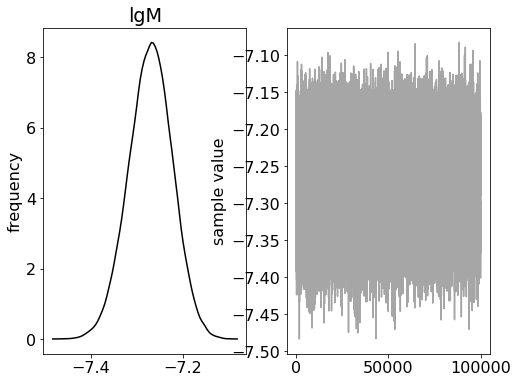

In [600]:
ee = fit_cp_lgm.plot(['lgM'])

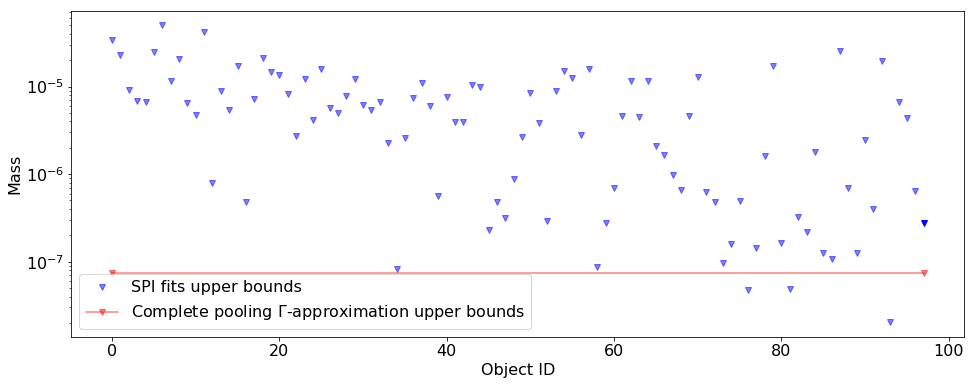

In [602]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(len(flux_posterior_alpha_all))[0:-1],mass_limits,'bv',\
         label='SPI fits upper bounds',alpha=0.5)
plt.plot(97,27.3e-8,'bv')
plt.plot([0,97],
         np.repeat(10**np.percentile(fit_cp_lgm['lgM'],99.85,axis=0),2),'rv-',
         label=r'Complete pooling $\Gamma$-approximation upper bounds',alpha=0.5)
plt.legend()
plt.xlabel('Object ID')
plt.ylabel(r'Mass')
plt.yscale('log')

<h3>The mass limit from the population is slightly worse than the limit from the best single source, at $< 7 \times 10^{-8}\,\mathrm{M_{\odot}}$.<br>
    Note that this assumes that <em>all</em> novae would contribute. We know, however, that only 1/3 are ONe novae, but don't know which. We will handle this with a mixture model, so that we marginalise over all possibilities.<br>But first the partial pooling model.</h3>

In [609]:
10**np.percentile(fit_cp_lgm['lgM'],99.85,axis=0)*1e8

7.333473755796362

In [606]:
10**np.percentile(fit_cp_lgm['lgM'],50,axis=0)*1e8

5.372986697575283

In [607]:
(10**np.percentile(fit_cp_lgm['lgM'],50-68.3/2,axis=0)-10**np.percentile(fit_cp_lgm['lgM'],50,axis=0))*1e8

-0.5689677164358207

In [615]:
(10**np.percentile(fit_cp_lgm['lgM'],50+68.3/2,axis=0)-10**np.percentile(fit_cp_lgm['lgM'],50,axis=0))*1e8

0.6083838139070744

In [616]:
10**np.percentile(fit_cp_lgm['lgM'],np.array([5,95.]))*1e8

array([4.46212372, 6.40545466])

<h3>Partial Pooling Masses:</h3>

In [624]:
na22_partial_pooling_srcs =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
 
    // ejected mass
    real lgM_min;                  // lower bound of sampling region of lgM (to avoid uninteresting regions)
 
    // if distance is not known, use global distrribution, approximated by gamma distribution with fixed parameters
    real distance_alpha[N-1];      // gamma distribution alpha parameter for distance; or mean of normal distribution
    real distance_beta[N-1];       // gamma distribution beta parameters (=1/theta) for distance; or width of normal distribution
    int known_dist_idx[N];         // index for objects with known distance (diffuse distance known)
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;
    // vector[N] flux_stds = 3.5 * sqrt(fluxes_alpha) ./ fluxes_beta;
}

parameters {
    real<lower=lgM_min,upper=-4> mu_lgM;
    real<lower=0> tau_lgM;
    vector[N] eta;
    real<lower=0.1,upper=40.0> dist[N-1];
    real<lower=1.,upper=150.> R_CN;
}


transformed parameters {

    real flux[N]; // calculate flux

    vector[N] lgM;
    lgM = mu_lgM + tau_lgM * eta;

    for (n in 1:N) {

        if (known_dist_idx[n] < 2) { // flag for point source (0 or 1) or diffuse (2)

            flux[n] = exp(19.765621 + 2.3026*lgM[n] - 2*log(dist[n]));

        } else {

            flux[n] = exp(17.781483 + 2.3026*lgM[n] + log(R_CN));

        }

    }

}


model {
    eta ~ normal(0, 1);
    mu_lgM ~ uniform(-20,-4);
    tau_lgM ~ cauchy(0,1);
    // tau_lgM ~ uniform(0,10);
    //lgM ~ normal(mu_lgM,tau_lgM);                              // normal prior(s) for log mass

    for (n in 1:N-1) {

        if (known_dist_idx[n] == 1) {

            dist[n] ~ normal(distance_alpha[n],distance_beta[n]);

        } else {

            dist[n] ~ gamma(4.25,0.408);                        // gamma prior(s) for the dist

        }

    }

    # Shafter+2017 nova rate 50+25/yr for CO novae (~1/3 for ONe novae, there fore use 17+-8)
    R_CN ~ normal(50./3,25./3);
    
    
    
    for (n in 1:N) {
        flux_means[n] ~ gamma(flux[n]*fluxes_beta[n], fluxes_beta[n]);
    }
    
    
}

"""

In [625]:
model_pp_lgm = pystan.StanModel(model_code=na22_partial_pooling_srcs)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd8666085ef15cac16d211791a1bf5a0 NOW.


In [626]:
data_pp   = dict(N               = len(flux_posterior_alpha_all),
              fluxes_alpha    = flux_posterior_alpha_all,
              fluxes_beta     = flux_posterior_beta_all,
              lgM_min         = -20, # we use a very low limit to not disturb anything
              distance_alpha  = dist_arr,
              distance_beta   = dist_arr_err,
              known_dist_idx  = known_dist_idx.astype(int))

In [627]:
fit_pp_lgm = model_pp_lgm.sampling(data=data_pp,chains=10,iter=20000)

In [628]:
print(fit_pp_lgm.stansummary(['mu_lgM','tau_lgM','lgM','flux','lp__'],probs=[0.0015,0.5,0.9985]))

Inference for Stan model: anon_model_dd8666085ef15cac16d211791a1bf5a0.
10 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=100000.

           mean se_mean     sd  0.15%    50% 99.85%  n_eff   Rhat
mu_lgM    -6.93  3.0e-4   0.08  -7.17  -6.93  -6.69  69274    1.0
tau_lgM    0.52  3.1e-4   0.07   0.34   0.52   0.75  48068    1.0
lgM[1]    -6.58  1.2e-3   0.46  -7.99  -6.58  -5.27 134202    1.0
lgM[2]    -6.56  1.3e-3   0.46  -7.98  -6.55  -5.23 134149    1.0
lgM[3]    -6.73  1.1e-3   0.42  -8.08  -6.72  -5.53 136822    1.0
lgM[4]    -6.75  1.2e-3   0.42   -8.1  -6.75  -5.57 131963    1.0
lgM[5]     -6.8  1.1e-3   0.41  -8.11  -6.79  -5.65 139005    1.0
lgM[6]     -6.6  1.2e-3   0.45  -7.98  -6.59  -5.31 137390    1.0
lgM[7]    -6.52  1.3e-3   0.47  -7.94  -6.51  -5.14 140561    1.0
lgM[8]    -6.69  1.2e-3   0.43  -8.05  -6.68  -5.47 133606    1.0
lgM[9]    -6.65  1.2e-3   0.44  -8.02  -6.64  -5.41 137871    1.0
lgM[10]   -6.

<h3>Note that $\mu$ and $\tau$ do not have a very clear meaning now, because we didn't fit to the SPI data, but to the extracted fluxes (1.5 million data points vs. 98). However, we can clearly see the structure that we would expect from such a hierarchical model, and can, nevertheless, extract information from our fit to give robust upper bounds on our parameters of interest:</h3>

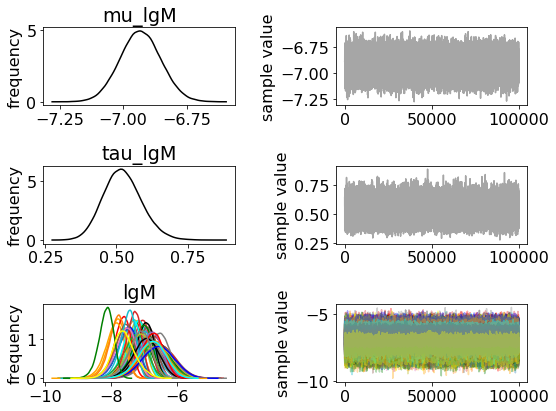

In [629]:
ff = fit_pp_lgm.plot(['mu_lgM','tau_lgM','lgM'])
plt.tight_layout();

<h3>Partial Pooling marginalised over all other parameters:</h3>

In [755]:
print('Upper bound on ejected Na-22 mass (x 1e-7 Msun) from nova population: '+\
      str('%.1f' % (10**np.percentile(fit_pp_lgm['mu_lgM'],99.85)*1e7)+'.'))

Upper bound on ejected Na-22 mass (x 1e-7 Msun) fromnova population: 2.1.


<h3>Compared to Complete Pooling:</h3>

In [764]:
print('Upper bound on ejected Na-22 mass (x 1e-7 Msun) from nova population: '+\
      str('%.1f' % (10**np.percentile(fit_cp_lgm['lgM'],99.85)*1e7)+'.'))

Upper bound on ejected Na-22 mass (x 1e-7 Msun) from nova population: 0.7.


<h3>We see that $\tau$ is actually very much constrained to a small range around $0.5$. That means, our samples do not contain the information about a larger range of $\tau \rightarrow 0$ (Complete Pooling), or $\tau \rightarrow \infinity$ (No Pooling). We therefore fix $\tau$ and extract the posterior information for a set of $\tau$ values:</h3>

In [672]:
na22_partial_pooling_srcs_calc_tau =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
 
    // ejected mass
    real lgM_min;                  // lower bound of sampling region of lgM (to avoid uninteresting regions)
 
    // if distance is not known, use global distrribution, approximated by gamma distribution with fixed parameters
    real distance_alpha[N-1];      // gamma distribution alpha parameter for distance; or mean of normal distribution
    real distance_beta[N-1];       // gamma distribution beta parameters (=1/theta) for distance; or width of normal distribution
    int known_dist_idx[N];         // index for objects with known distance (diffuse distance known)
    
    real tau_lgM;  // for calculation?
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;
    // vector[N] flux_stds = 3.5 * sqrt(fluxes_alpha) ./ fluxes_beta;
}

parameters {
    real<lower=lgM_min,upper=-4> mu_lgM;
    //real<lower=0> tau_lgM;
    vector[N] eta;
    real<lower=0.1,upper=40.0> dist[N-1];
    real<lower=1.,upper=150.> R_CN;
}


transformed parameters {

    real flux[N]; // calculate flux

    vector[N] lgM;
    lgM = mu_lgM + tau_lgM * eta;

    for (n in 1:N) {

        if (known_dist_idx[n] < 2) { // flag for point source (0 or 1) or diffuse (2)

            flux[n] = exp(19.765621 + 2.3026*lgM[n] - 2*log(dist[n]));

        } else {

            flux[n] = exp(17.781483 + 2.3026*lgM[n] + log(R_CN));

        }

    }

}


model {
    eta ~ normal(0, 1);
    mu_lgM ~ uniform(-20,-4);
    tau_lgM ~ cauchy(0,1);
    // tau_lgM ~ uniform(0,10);
    //lgM ~ normal(mu_lgM,tau_lgM);                              // normal prior(s) for log mass

    for (n in 1:N-1) {

        if (known_dist_idx[n] == 1) {

            dist[n] ~ normal(distance_alpha[n],distance_beta[n]);

        } else {

            dist[n] ~ gamma(4.25,0.408);                        // gamma prior(s) for the dist

        }

    }

    # Shafter+2017 nova rate 50+25/yr for CO novae (~1/3 for ONe novae, there fore use 17+-8)
    R_CN ~ normal(50./3,25./3);
    
    
    
    for (n in 1:N) {
        flux_means[n] ~ gamma(flux[n]*fluxes_beta[n], fluxes_beta[n]);
    }
    
    
}

"""

In [673]:
model_pp_lgm_tau = pystan.StanModel(model_code=na22_partial_pooling_srcs_calc_tau)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6544400d83eae31f4ce8998d76394c8 NOW.


<h3>50 logarithmically binned $\tau$ values between $0.01$ and $10$.</h3>

In [703]:
tau_arr_pp = np.logspace(-2,1,50)
tau_arr_pp

array([ 0.01      ,  0.01151395,  0.01325711,  0.01526418,  0.01757511,
        0.0202359 ,  0.02329952,  0.02682696,  0.03088844,  0.0355648 ,
        0.04094915,  0.04714866,  0.05428675,  0.06250552,  0.07196857,
        0.08286428,  0.09540955,  0.10985411,  0.12648552,  0.14563485,
        0.16768329,  0.19306977,  0.22229965,  0.25595479,  0.29470517,
        0.33932218,  0.39069399,  0.44984327,  0.51794747,  0.59636233,
        0.68664885,  0.79060432,  0.91029818,  1.04811313,  1.20679264,
        1.38949549,  1.59985872,  1.84206997,  2.12095089,  2.44205309,
        2.8117687 ,  3.23745754,  3.72759372,  4.29193426,  4.94171336,
        5.68986603,  6.55128557,  7.54312006,  8.68511374, 10.        ])

<h3>Loop over $\tau$-values:</h3>

In [705]:
N_src = 98
N_tau = len(tau_arr_pp)

lgM_arr_median = np.zeros((N_src,N_tau))
lgM_arr_ub = np.zeros((N_src,N_tau))

lgM_arr_mu_median = np.zeros(N_tau)
lgM_arr_mu_ub = np.zeros(N_tau)

for i in tqdm(range(N_tau)):
    data_pp_tau = dict(N               = len(flux_posterior_alpha_all),
                       fluxes_alpha    = flux_posterior_alpha_all,
                       fluxes_beta     = flux_posterior_beta_all,
                       lgM_min         = -20, # we use a very low limit to not disturb anything
                       distance_alpha  = dist_arr,
                       distance_beta   = dist_arr_err,
                       known_dist_idx  = known_dist_idx.astype(int),
                       tau_lgM         = tau_arr_pp[i])
    
    fit_pp_lgm_tau = model_pp_lgm_tau.sampling(data=data_pp_tau,chains=10,iter=2000)
    
    lgM_arr_median[:,i] = np.percentile(fit_pp_lgm_tau['lgM'],50,axis=0)
    lgM_arr_ub[:,i] = np.percentile(fit_pp_lgm_tau['lgM'],99.85,axis=0)
    
    lgM_arr_mu_median[i] = np.percentile(fit_pp_lgm_tau['mu_lgM'],50)
    lgM_arr_mu_ub[i] = np.percentile(fit_pp_lgm_tau['mu_lgM'],99.85)

<h3>Fancy plot showing the funnel and the posterior of $\tau$:</h3>

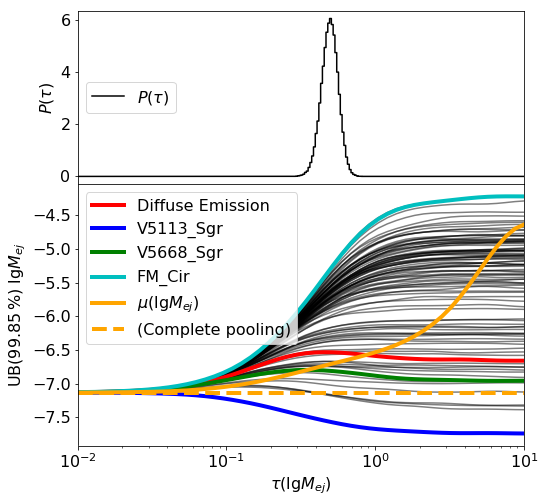

In [760]:
tau_bins = np.logspace(-2,10,1000)
tau_dat = np.histogram(fit_pp_lgm['tau_lgM'],bins=tau_bins,density=True);


fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,8),gridspec_kw={'height_ratios':[1.33,2]})#,subplot_kw={"aspect":0.33})

sf = 2.5
ax[1].plot(tau_arr_pp,smooth(lgM_arr_ub.T,2,axis=0),'k-',alpha=0.5);
ax[1].plot(tau_arr_pp,smooth(lgM_arr_ub[97,:],sf),'r-',linewidth=4,label='Diffuse Emission');
ax[1].plot(tau_arr_pp,smooth(lgM_arr_ub[93,:],sf),'b-',linewidth=4,label='V5113_Sgr');
ax[1].plot(tau_arr_pp,smooth(lgM_arr_ub[34,:],sf),'g-',linewidth=4,label='V5668_Sgr');
ax[1].plot(tau_arr_pp,smooth(lgM_arr_ub[6,:],sf),'c-',linewidth=4,label='FM_Cir');
ax[1].plot(tau_arr_pp,smooth(lgM_arr_mu_ub,sf),color='orange',linestyle='-',linewidth=4,
           label=r'$\mu(\lg M_{ej} )$');
ax[1].axhline(np.percentile(fit_cp_lgm['lgM'],99.85),color='orange',linestyle='--',linewidth=4,
              label=r'(Complete pooling)')

ax[1].set_xscale('log')
ax[1].set_xlim(1e-2,10)
#ax[1].set_xlim(0,2)
ax[1].set_xlabel(r'$\tau(\lg M_{ej} )$')
ax[1].set_ylabel(r'UB(99.85$\,\%$) $\lg M_{ej}$')


ax[1].legend()


plt.subplots_adjust(hspace=0)

ax[0].step(tau_dat[1][0:-1],tau_dat[0],where='pre',label=r'$P(\tau)$')

#ax[0].plot(x,truncated_cauchy(x,[0,2,0,np.inf]),color='red',linestyle='--',label=r'$\mathscr{C}_{0}^{+}(0,2)$')
#ax[0].plot(x,np.repeat(0.1,len(x)),color='red',label=r'$\mathscr{U}(0,10)$')

ax[0].set_ylabel(r'$P(\tau)$')
ax[0].set_xscale('log')
ax[0].set_xlim(1e-2,10)
#ax[0].set_xlim(0,2)
#ax[0].set_ylim(0,0.39)
ax[0].set_xticks([])

ax[0].legend(loc=6)

plt.savefig('Hierarchical_Model_Posterior_Bounds_Tau_Na22.pdf')

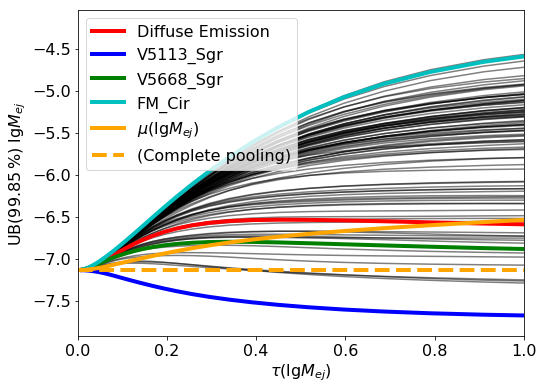

In [763]:
tau_bins = np.logspace(-2,10,1000)
tau_dat = np.histogram(fit_pp_lgm['tau_lgM'],bins=tau_bins,density=True);


fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))#,gridspec_kw={'height_ratios':[1.33,2]})#,subplot_kw={"aspect":0.33})

sf = 2.5
ax.plot(tau_arr_pp,smooth(lgM_arr_ub.T,2,axis=0),'k-',alpha=0.5);
ax.plot(tau_arr_pp,smooth(lgM_arr_ub[97,:],sf),'r-',linewidth=4,label='Diffuse Emission');
ax.plot(tau_arr_pp,smooth(lgM_arr_ub[93,:],sf),'b-',linewidth=4,label='V5113_Sgr');
ax.plot(tau_arr_pp,smooth(lgM_arr_ub[34,:],sf),'g-',linewidth=4,label='V5668_Sgr');
ax.plot(tau_arr_pp,smooth(lgM_arr_ub[6,:],sf),'c-',linewidth=4,label='FM_Cir');
ax.plot(tau_arr_pp,smooth(lgM_arr_mu_ub,sf),color='orange',linestyle='-',linewidth=4,
           label=r'$\mu(\lg M_{ej} )$');
ax.axhline(np.percentile(fit_cp_lgm['lgM'],99.85),color='orange',linestyle='--',linewidth=4,
              label=r'(Complete pooling)')

#ax.set_xscale('log')
#ax.set_xlim(1e-2,10)
ax.set_xlim(0,1)
ax.set_xlabel(r'$\tau(\lg M_{ej} )$')
ax.set_ylabel(r'UB(99.85$\,\%$) $\lg M_{ej}$')


ax.legend()


plt.savefig('Hierarchical_Model_Posterior_Na22.pdf')

<h3>Finite mixture model (ONe vs CO) with known proportions to identify upper bound:</h3>

In [1153]:
na22_complete_pooling_srcs_mix =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
 
    // ejected mass
    real mu_lgM[2];                   // prior for the log mass of ALL objects
    real sigma_lgM[2];                // width of log mass prior
    real lgM_min;                  // lower bound of sampling region of lgM (to avoid uninteresting regions)
 
    // if distance is not known, use global distrribution, approximated by gamma distribution with fixed parameters
    real distance_alpha[N-1];      // gamma distribution alpha parameter for distance; or mean of normal distribution
    real distance_beta[N-1];       // gamma distribution beta parameters (=1/theta) for distance; or width of normal distribution
    int known_dist_idx[N];         // index for objects with known distance (diffuse distance known)
}

transformed data {

    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;         // flux means
    // vector[N] flux_stds = sqrt(fluxes_alpha) ./ fluxes_beta; // not needed

    simplex[2] theta; // proportions for mixture (1/3 ONe, 2/3 CO)
    theta[1] = 1./3;
    theta[2] = 2./3;
    

    
    print(flux_means); // cross check
    

}

parameters {
    vector[2] lgM   ;  // mass for ALL CO objects and ALL ONe objects
    real<lower=0.1,upper=40.0> dist[N-1];       // distance for each object
    real<lower=1.,upper=150.> R_CN;             // nota rate for diffuse emission
}


transformed parameters {

    real flux[2,N]; // calculate flux

    for (k in 1:2) {
        for (n in 1:N) {

            if (known_dist_idx[n] < 2) { // flag for point source (0 or 1) or diffuse (2)

                flux[k,n] = exp(19.765621 + 2.3026*lgM[k] - 2*log(dist[n]));

            } else {

                flux[k,n] = exp(17.781483 + 2.3026*lgM[1] + log(R_CN));

            }

        }
        
    }

}


model {
    
    //vector[2] log_theta = log(theta);  // cache log calculation
    
    lgM[1] ~ normal(mu_lgM[1],sigma_lgM[1]);     // normal prior for log mass (ONe)
    lgM[2] ~ normal(mu_lgM[2],sigma_lgM[2]);     // normal prior for log mass (CO)

    for (n in 1:N-1) { // loop over objects

        if (known_dist_idx[n] == 1) { // if distance known, use gaussian prior

            dist[n] ~ normal(distance_alpha[n],distance_beta[n]);

        } else { // if not generic gamma prior

            dist[n] ~ gamma(4.25,0.408);                        // gamma prior(s) for the dist

        }

    }

    # Shafter+2017 nova rate 50+25/yr for CO novae (~1/3 for ONe novae, there fore use 17+-8)
    R_CN ~ normal(50./3,25./1000); // ONe nova rate
    
    
    
    //for (n in 1:N) {
    //    flux_means[n] ~ gamma(flux[n]*fluxes_beta[n], fluxes_beta[n]);
    //}
    
    

    for (n in 1:N) {
        //vector[2] lps = log_theta;
        //for (k in 1:2) {
        //    lps[k] += gamma_lpdf(flux_means[n] | flux[k,n]*fluxes_beta[n], fluxes_beta[n]);
        //}
        target += log_sum_exp(log(theta[1]) + gamma_lpdf(flux_means[n] | flux[1,n]*fluxes_beta[n], fluxes_beta[n]),
                              log(theta[2]) + gamma_lpdf(flux_means[n] | flux[2,n]*fluxes_beta[n], fluxes_beta[n]));
    }
    
    
    
}

"""

In [1154]:
model_cp_lgm_mix = pystan.StanModel(model_code=na22_complete_pooling_srcs_mix)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16893e0d9975de10bb0a5e8b9a47e171 NOW.


In [1195]:
data_mix   = dict(N               = len(flux_posterior_alpha_all),
              fluxes_alpha    = flux_posterior_alpha_all,
              fluxes_beta     = flux_posterior_beta_all,
              mu_lgM          = [-7,-12],
              sigma_lgM       = [1,0.25], # basically leave everything unconstrained
              lgM_min         = -20, # we use a very low limit to not disturb anything
              distance_alpha  = dist_arr,
              distance_beta   = dist_arr_err,
              known_dist_idx  = known_dist_idx.astype(int))

In [1196]:
fit_cp_lgm_mix = model_cp_lgm_mix.sampling(data=data_mix,chains=1,iter=10000)

In [1197]:
print('Upper bound on ejected Na-22 mass (x 1e-7 Msun) from nova population: '+\
      str('%.2f' % (10**np.percentile(fit_cp_lgm['lgM'],99.85)*1e7)+'.'))

Upper bound on ejected Na-22 mass (x 1e-7 Msun) from nova population: 0.73.


In [1203]:
print('Upper bound on ejected Na-22 mass (x 1e-7 Msun) from nova population: '+\
      str('%.2f' % (10**np.percentile(fit_cp_lgm_mix['lgM'],99.85,axis=0)[0]*1e7)+'.'))

Upper bound on ejected Na-22 mass (x 1e-7 Msun) from nova population: 0.89.


In [1199]:
10**np.percentile(fit_cp_lgm_mix['lgM'],99.85,axis=0)

array([8.93110316e-08, 1.57514599e-11])

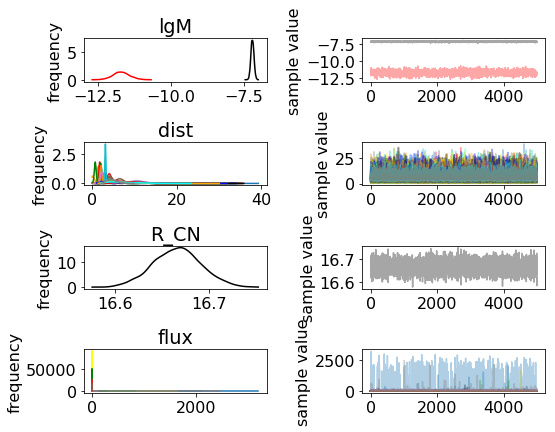

In [1201]:
fit_cp_lgm_mix.plot();
plt.tight_layout()

In [1202]:
print(fit_cp_lgm_mix.stansummary(['lgM','R_CN'],probs=[0.0015,0.5,0.9985]))

Inference for Stan model: anon_model_16893e0d9975de10bb0a5e8b9a47e171.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

         mean se_mean     sd  0.15%    50% 99.85%  n_eff   Rhat
lgM[1]  -7.21  1.6e-3   0.05  -7.37  -7.21  -7.05   1118    1.0
lgM[2]  -11.7  8.1e-3   0.29 -12.54  -11.7  -10.8   1238    1.0
R_CN    16.67  2.2e-4   0.03   16.6  16.67  16.74  13575    1.0

Samples were drawn using NUTS at Wed Nov 18 21:25:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<h1>Be7 starting here!</h1>

In [1206]:
results_dir_be7 = '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/be7/'

In [1207]:
result_files_be7final = []

for subdir, dirs, files in os.walk(results_dir_be7):
    for file in files:
        if os.path.join(subdir, file).endswith('final.npz'):
            result_files_be7final.append(os.path.join(subdir, file))

In [1208]:
result_files_be7final = np.array(result_files_be7final)

In [1209]:
len(result_files_be7final)

98

In [1210]:
sdxbe7 = np.argsort(result_files_be7final)
result_files_be7final = result_files_be7final[sdxbe7]
result_files_be7final = result_files_be7final[1:]
result_files_be7final

array(['/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/be7/004_V5857_Sgr/save_StanFit_mass_NovaV5857_Sgr_final.npz',
       '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/be7/006_V906_Car/save_StanFit_mass_NovaV906_Car_final.npz',
       '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/be7/007_V3665_Oph/save_StanFit_mass_NovaV3665_Oph_final.npz',
       '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/be7/008_V1663_Sco/save_StanFit_mass_NovaV1663_Sco_final.npz',
       '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/be7/009_V3664_Oph/save_StanFit_mass_NovaV3664_Oph_final.npz',
       '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/be7/010_V1662_Sco/save_StanFit_mass_NovaV1662_Sco_final.npz',
       '/Users/thomassiegert/python/testing/for-students/nova_analysis/downloads/be7/011_FM_Cir/save_StanFit_mass_NovaFM_Cir_final.npz',
       

In [1211]:
def const_flux7(d,f):
    return np.log10(d**2*f/22769)

In [1212]:
plot_fluxes = np.array([1e-2,1e-3,1e-4,1e-5,1e-6,3e-5,3e-4,3e-6,3e-3,3e-7])
text_fluxes = np.array([r'$10^{-2}$',r'$10^{-3}$',r'$10^{-4}$',r'$10^{-5}$',r'$10^{-6}$'])
posi_fluxes = np.array([[0.5,0.5,0.5,0.6,1.9],[-6.7,-7.7,-8.7,-9.5,-9.5]])

23 028 V5854_Sgr 2.6278478867061867


/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/bayescorner/compute_sigma_level.py:21: RuntimeWarning: divide by zero encountered in log
  logL = np.log(L)


36 041 V5666_Sgr 2.066567188005676
44 049 V5592_Sgr 2.0735918761137198


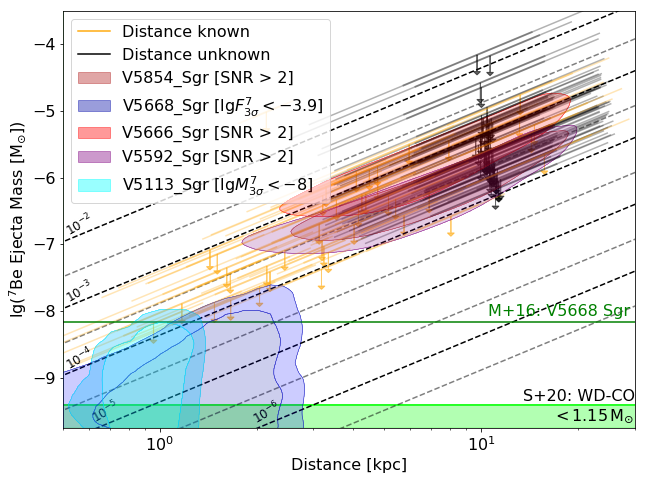

In [1213]:
flux_limits_be7 = []
mass_limits_be7 = []
distances_f_be7 = []
obj_names_f_be7 = []


fig, ax = plt.subplots(figsize=(10.24,7.68))
ax.set_xlim(0.5,30)
ax.set_ylim(-9.75,-3.5)
ax.set_xscale('log')
ax.set_xlabel('Distance [kpc]')
ax.set_ylabel(r'lg($^{7}\mathrm{Be}$ Ejecta Mass [$\mathrm{M_{\odot}}$])')

cnt = 0

for i in range(len(plot_fluxes)):
    if i < 5:
        ax.plot(d_arr,const_flux7(d_arr,plot_fluxes[i]),color='black',linestyle='--')
        ax.text(posi_fluxes[0,i],posi_fluxes[1,i],text_fluxes[i],rotation=30,fontsize=12)
    else:
        ax.plot(d_arr,const_flux7(d_arr,plot_fluxes[i]),color='black',linestyle='--',alpha=0.5)
    
for i in range(len(result_files_be7final)):
    with np.load(result_files_be7final[i]) as content:
        flux_tmp = content['fit_tmp_flux']
        dist_tmp = content['fit_tmp_dist']
        lgM_tmp = content['fit_tmp_lgM']    

        
    flux_limits_be7.append(np.percentile(flux_tmp[:,0],99.85)*1e-5)
    mass_limits_be7.append(np.percentile(10**lgM_tmp[:,0],99.85))
    distances_f_be7.append(np.mean(dist_tmp[:,0]))
    
    obj_names_f_be7.append(result_files_be7final[i].split(results_dir_be7)[1].split('/')[0][4:])
    
    if (np.median(flux_tmp[:,0])/np.std(flux_tmp[:,0]) < 2.0):
        
        d_med = np.median(dist_tmp[:,0])
        d_std = np.std(dist_tmp[:,0])
        dm_min1 = np.percentile(dist_tmp[:,0],50-68.3/2)#d_med-d_std
        dm_max1 = np.percentile(dist_tmp[:,0],50+68.3/2)#d_med+d_std
        dm_min2 = np.percentile(dist_tmp[:,0],50-95.4/2)#d_med-2*d_std
        dm_max2 = np.percentile(dist_tmp[:,0],50+95.4/2)#d_med+2*d_std
        ddx = np.where((dist_tmp[:,0] > dm_min1) & (dist_tmp[:,0] < dm_max1))
        ddxm1 = np.where((dist_tmp[:,0] > dm_min2) & (dist_tmp[:,0] < dm_min1))
        ddxp1 = np.where((dist_tmp[:,0] > dm_max1) & (dist_tmp[:,0] < dm_max2))

        lgM_med = np.percentile(lgM_tmp[ddx,0],99)
        lgMm_min1 = 2*np.log10(dm_min1)-2*np.log10(d_med)+np.percentile(lgM_tmp[ddx,0],99)
        lgMm_max1 = 2*np.log10(dm_max1)-2*np.log10(d_med)+np.percentile(lgM_tmp[ddx,0],99)
        lgMm_min2 = 2*np.log10(dm_min2)-2*np.log10(d_med)+np.percentile(lgM_tmp[ddx,0],99)
        lgMm_max2 = 2*np.log10(dm_max2)-2*np.log10(d_med)+np.percentile(lgM_tmp[ddx,0],99)

        #ax.contourf(xbins, ybins, sigma, levels=[0,0.90], colors=color_unknown, alpha=.05,zorder=-100)
        #ax.plot([d_med],[lgM_med],'k',alpha=0.3,markersize=20,marker=(3, 0, 90))
        if ((d_med > 9.5) & (d_med < 11.5)):
            ax.arrow(d_med, lgM_med, 0, -0.25, head_width=0.05*d_med, head_length=0.05, fc='k', ec='k',alpha=0.6)
            ax.plot([dm_min1,dm_max1],[lgMm_min1,lgMm_max1],'k-',alpha=0.3,linewidth=2)
            ax.plot([dm_min2,dm_max2],[lgMm_min2,lgMm_max2],'k-',alpha=0.3)
        else:
            ax.arrow(d_med, lgM_med, 0, -0.25, head_width=0.05*d_med, head_length=0.05, fc='xkcd:yellowish orange', ec='xkcd:yellowish orange',alpha=0.6)
            ax.plot([dm_min1,dm_max1],[lgMm_min1,lgMm_max1],color='xkcd:yellowish orange',linestyle='-',alpha=0.3,linewidth=2)
            ax.plot([dm_min2,dm_max2],[lgMm_min2,lgMm_max2],color='xkcd:yellowish orange',linestyle='-',alpha=0.3)
        
        if (i ==34):#(i == 34) | (i == 84) | (i == 89) :
            d_med = np.median(dist_tmp[:,0])
            d_std = np.std(dist_tmp[:,0])
            
            xbins, ybins, sigma = bayescorner.compute_sigma_level.compute_sigma_level(
            dist_tmp[:,0], lgM_tmp[:,0], ymin=-10.5, ymax=-4, xmin=0, xmax=40, nbins=200)
        
            known_color = see_colors[cnt]#[np.int(np.random.rand()*5)]#plt.cm.jet(np.random.rand(3))
            ax.contourf(xbins, ybins, sigma, levels=[0,0.683,0.9], colors=['xkcd:cobalt blue','blue'], alpha=.2,zorder=1000)
            ax.contour(xbins,ybins,sigma,levels=[0.683,0.9], colors='xkcd:cobalt blue',linewidths=0.5)
            ax.fill_between(np.repeat(100,5),np.repeat(-100,5), color='xkcd:cobalt blue', alpha=.4,
                           label=result_files_be7final[i].split(results_dir_be7)[1].split('/')[0][4:]+
                           str(r' [$\lg F_{3\sigma}^{7} < -3.9$]'))
            
        if (i == 93):#(i == 34) | (i == 84) | (i == 89) :
            d_med = np.median(dist_tmp[:,0])
            d_std = np.std(dist_tmp[:,0])
            
            xbins, ybins, sigma = bayescorner.compute_sigma_level.compute_sigma_level(
            dist_tmp[:,0], lgM_tmp[:,0], ymin=-10.5, ymax=-4, xmin=0, xmax=40, nbins=200)
        
            known_color = see_colors[cnt]#[np.int(np.random.rand()*5)]#plt.cm.jet(np.random.rand(3))
            ax.contourf(xbins, ybins, sigma, levels=[0,0.683,0.9], colors=['cyan','deepskyblue'], alpha=.3,zorder=1000)
            ax.contour(xbins,ybins,sigma,levels=[0.683,0.9], colors='cyan',linewidths=0.5)
            ax.fill_between(np.repeat(100,5),np.repeat(-100,5), color='cyan', alpha=.4,
                           label=result_files_be7final[i].split(results_dir_be7)[1].split('/')[0][4:]+
                           str(r' [$\lg M_{3\sigma}^{7} < -8$]'))
        
    else:
        
        d_med = np.median(dist_tmp[:,0])
        d_std = np.std(dist_tmp[:,0])
        print(i,
              result_files_be7final[i].split(results_dir_be7)[1][0:3],
              result_files_be7final[i].split(results_dir_be7)[1].split('/')[0][4:],
              np.median(flux_tmp[:,0])/np.std(flux_tmp[:,0]))
        xbins, ybins, sigma = bayescorner.compute_sigma_level.compute_sigma_level(
        dist_tmp[:,0], lgM_tmp[:,0], ymin=-10.5, ymax=-4, xmin=0, xmax=40, nbins=200)

        known_color = see_colors[cnt:cnt+2]#[np.int(np.random.rand()*5)]#plt.cm.jet(np.random.rand(3))
        ax.contourf(xbins, ybins, sigma, levels=[0,0.683], colors=known_color, alpha=.2,zorder=1000)
        ax.contour(xbins,ybins,sigma,levels=[0.683], colors=known_color,linewidths=0.5)
        ax.fill_between(np.repeat(100,5),np.repeat(-100,5), color=known_color, alpha=.4,
                       label=result_files_be7final[i].split(results_dir_be7)[1].split('/')[0][4:]+
                       str(r' [SNR > 2]'))

        cnt += 1
        
        
ax.plot([100,100],[-10,-10], color='xkcd:yellowish orange',alpha=1,label='Distance known')
ax.plot([100,100],[-10,-10], color='black',alpha=1,label='Distance unknown')
    
ax.legend()

ax.axhline(np.log10(7e-9),color='green')
ax.text(29,-8,'M+16: V5668 Sgr',horizontalalignment='right',verticalalignment='center',color='green')

ax.axhline(np.log10(4e-10),color='lime',zorder=-1000)
ax.fill_between([0.5,0.5,30,50,0.5],
                [np.log10(4e-10),-9.75,
                 -9.75,np.log10(4e-10),
                 np.log10(4e-10)],color='lime',alpha=0.3,zorder=-1000)
ax.text(30,-9.45,'S+20: WD-CO\n'+r'$<1.15\,\mathrm{M_{\odot}}$',
        horizontalalignment='right',verticalalignment='center')

plt.savefig('Summary_plot_7Be_lgM_dist_flux.pdf')

flux_limits_be7 = np.array(flux_limits_be7)
mass_limits_be7 = np.array(mass_limits_be7)
distances_f_be7 = np.array(distances_f_be7)

obj_names_f_be7 = np.array(obj_names_f_be7)

In [1214]:
low_flux_idx_be7 = flux_limits_be7 < 1.5e-4
print(np.where(low_flux_idx_be7 == True))
print(flux_limits_be7[low_flux_idx_be7])
print(mass_limits_be7[low_flux_idx_be7])
print(distances_f_be7[low_flux_idx_be7])
print(obj_names_f_be7[low_flux_idx_be7])

(array([34, 65]),)
[0.00013986 0.00014047]
[3.19534229e-08 5.27012126e-07]
[1.68663673 8.03385295]
['V5668_Sgr' 'V1721_Aql']


In [1216]:
low_mass_idx_be7 = mass_limits_be7 < 5e-8
print(np.where(low_mass_idx_be7 == True))
print(flux_limits_be7[low_mass_idx_be7])
print(mass_limits_be7[low_mass_idx_be7])
print(distances_f_be7[low_mass_idx_be7])
print(obj_names_f_be7[low_mass_idx_be7])

(array([34, 76, 80, 81, 93]),)
[0.00013986 0.00024377 0.00017054 0.00018244 0.00018366]
[3.19534229e-08 3.02483392e-08 4.13309655e-08 2.35352744e-08
 9.66150143e-09]
[1.68663673 1.20003293 2.10348164 1.47962123 0.96405292]
['V5668_Sgr' 'V1280_Sco' 'V2576_Oph' 'V5117_Sgr' 'V5113_Sgr']


In [1238]:
print('Upper bound on 4.78 MeV flux (lg-units) of V5668 Sgr: '+\
      str('%.1f' % (np.log10(flux_limits_be7[34]))+'.'))
print('Upper bound on ejected Be-7 mass (lg-units) of V5113 Sgr: '+\
      str('%.1f' % (np.log10(mass_limits_be7[93]))+'.'))

Upper bound on 4.78 MeV flux (lg-units) of V5668 Sgr: -3.9.
Upper bound on ejected Be-7 mass (lg-units) of V5113 Sgr: -8.0.


In [1223]:
# ejecta mass limit higher than lower (though highest) limit of theory prediction of Starrfield+2020
obj_names_f[np.where(mass_limits < 4e-10)]

array([], dtype='<U9')

In [1237]:
# ejecta mass limit higher than lower (though highest) limit of theory prediction of Starrfield+2020
obj_names_f[np.where(mass_limits < 4e-10*52)]

array(['V5113_Sgr'], dtype='<U9')

<h3>The upper bound from nova V5113 Sgr ($10^{-8}\,\mathrm{M_{\odot}}$) ist about a factor 50 higher than the highest theory prediction (S+20), and about the order of magnitude, the highest measurements inferred (M+16). Maybe we gain something from the diffuse emission and the combination of everything.</h3>

In [1241]:
with np.load(results_dir_be7+'000_Diffuse_Emission/save_StanFit_mass_NovaDiffuse_Emission_final.npz') as content:
    flux_tmp = content['fit_tmp_flux']
    R_CN_tmp = content['fit_tmp_R_CN']
    lgM_tmp = content['fit_tmp_lgM']
    #Abg_lines_tmp = content['fit_tmp_Abg_lines']
    #Abg_conti_tmp = content['fit_tmp_Abg_conti']

In [1242]:
flux_tmp[:,0].shape

(1000,)

In [1243]:
F_conti_set = 99.2 + np.random.randn(1000)*11.7 # diffuse continuum prior (S+16)

In [1245]:
flux_bounds_tmp = np.percentile(np.abs(flux_tmp[:,0]-F_conti_set),np.array([2.5,50,97.5]))*1e-5
flux_bounds_tmp
rcn_bounds_tmp = np.percentile(R_CN_tmp,np.array([2.5,50,97.5]))
rcn_bounds_tmp
mass_bounds_tmp = 10**np.percentile(lgM_tmp[:,0],np.array([2.5,50,97.5]))*1e8
mass_bounds_tmp
xbins, ybins, sigma = bayescorner.compute_sigma_level.compute_sigma_level(
    10**lgM_tmp[:,0]*1e8, R_CN_tmp, ymin=0, ymax=140, xmin=0, xmax=50, nbins=50)

In [1246]:
flux_bounds_tmp

array([1.01842300e-05, 1.69159576e-04, 4.92400227e-04])

In [1247]:
mass_bounds_tmp

array([ 0.01311255,  0.84920231, 11.96843898])

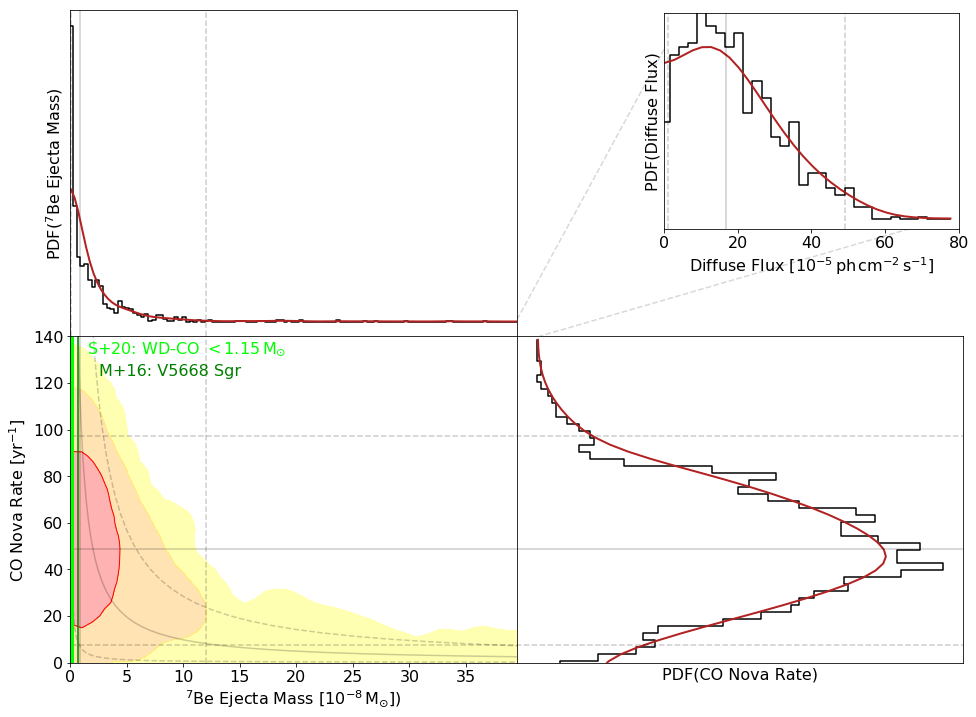

In [1248]:
fig, axes = plt.subplots(figsize=(16,12),nrows=2,ncols=2)

plt.subplots_adjust(hspace=0,wspace=0)

axes[1,0].contourf(xbins, ybins, sigma, levels=[0,0.683,0.954,0.997], colors=('red','orange','yellow'), alpha=.3)
cc = axes[1,0].contour(xbins, ybins, sigma, levels=[0,0.683], colors='red', linewidths=1)

axes[1,0].plot(lgM_arr,flux_bounds_tmp[0]/173.9/lgM_arr*1e8,color='black',linestyle='--',alpha=0.2)
axes[1,0].plot(lgM_arr,flux_bounds_tmp[1]/173.9/lgM_arr*1e8,color='black',linestyle='-',alpha=0.2)
axes[1,0].plot(lgM_arr,flux_bounds_tmp[2]/173.9/lgM_arr*1e8,color='black',linestyle='--',alpha=0.2)

axes[1,0].plot(lgM_arr,np.repeat(rcn_bounds_tmp[0],len(lgM_arr)),color='black',linestyle='--',alpha=0.2)
axes[1,0].plot(lgM_arr,np.repeat(rcn_bounds_tmp[1],len(lgM_arr)),color='black',linestyle='-',alpha=0.2)
axes[1,0].plot(lgM_arr,np.repeat(rcn_bounds_tmp[2],len(lgM_arr)),color='black',linestyle='--',alpha=0.2)

axes[1,0].plot(np.repeat(mass_bounds_tmp[0],2),[0,150],color='black',linestyle='--',alpha=0.2)
axes[1,0].plot(np.repeat(mass_bounds_tmp[1],2),[0,150],color='black',linestyle='-',alpha=0.2)
axes[1,0].plot(np.repeat(mass_bounds_tmp[2],2),[0,150],color='black',linestyle='--',alpha=0.2)

#axes[1,0].yscale('log')
axes[1,0].set_ylim(0.0,140)
axes[1,0].set_xlim(0,39.5)
axes[1,0].set_xlabel(r'$^{7}\mathrm{Be}$ Ejecta Mass [$10^{-8}\,\mathrm{M_{\odot}}$])')
axes[1,0].set_ylabel(r'CO Nova Rate [$\mathrm{yr^{-1}}$]')

axes[0,0].set_yticks([])
axes[0,0].set_xticks([])
axes[0,0].set_xlim(0,39.5)
axes[0,0].set_ylim(-0.04738430583501006, 0.9950704225352113)
axes[0,0].set_ylabel(r'PDF($^{7}\mathrm{Be}$ Ejecta Mass)')
axes[0,0].plot(np.repeat(mass_bounds_tmp[0],2),[-0.04738430583501006, 0.9950704225352113],color='black',linestyle='--',alpha=0.2)
axes[0,0].plot(np.repeat(mass_bounds_tmp[1],2),[-0.04738430583501006, 0.9950704225352113],color='black',linestyle='-',alpha=0.2)
axes[0,0].plot(np.repeat(mass_bounds_tmp[2],2),[-0.04738430583501006, 0.9950704225352113],color='black',linestyle='--',alpha=0.2)
hist_lgM = np.histogram(10**lgM_tmp[:,0]*1e8,bins=np.arange(-0.125,40,1/3),density=True)
axes[0,0].step(hist_lgM[1][0:-1]+1/6,hist_lgM[0],color='black',where='mid',)
axes[0,0].plot(hist_lgM[1][0:-1]+1/6,smooth(hist_lgM[0],3),color='firebrick',linewidth=2)
#hist_lgM = np.histogram(lgM_tmp[:,0],bins=np.arange(-10.6,-5.9,0.15),density=True)
#axes[0,0].step(hist_lgM[1][0:-1]+0.075,hist_lgM[0],color='black',where='mid',)
#axes[0,0].plot(hist_lgM[1][0:-1]+0.075,smooth(hist_lgM[0],3),color='firebrick',linewidth=2)
#axes[0,0].set_xlim(-10,-4)

axes[0,1].set_yticks([])
axes[0,1].set_xticks([])
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)
hist_flux = np.histogram(np.abs(flux_tmp[:,0]-F_conti_set),bins=np.arange(-0.75,80,2.5),density=True)
axin01 = axes[0,1].inset_axes([0.33, 0.33, 0.66, 0.66])
axin01.step(hist_flux[1][0:-1]+1,hist_flux[0],color='black',where='mid',)
axin01.plot(hist_flux[1][0:-1]+1,smooth(hist_flux[0],3),color='firebrick',linewidth=2)
axin01.set_xlabel(r'Diffuse Flux [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
axin01.set_ylabel(r'PDF(Diffuse Flux)')
axin01.set_yticks([])
axin01.plot(np.repeat(flux_bounds_tmp[0]*1e5,2),[-0.00162, 0.034019999999999995],color='black',linestyle='--',alpha=0.2)
axin01.plot(np.repeat(flux_bounds_tmp[1]*1e5,2),[-0.00162, 0.034019999999999995],color='black',linestyle='-',alpha=0.2)
axin01.plot(np.repeat(flux_bounds_tmp[2]*1e5,2),[-0.00162, 0.034019999999999995],color='black',linestyle='--',alpha=0.2)
axin01.set_ylim(-0.00162, 0.034019999999999995)
axin01.set_xlim(0,80)
axes[0,1].set_xlim(0,1)
axes[0,1].set_ylim(0,1)
axes[0,1].plot([0.88,0.05],[0.33,0],color='gray',linestyle='--',alpha=0.3)
axes[0,1].plot([0.33,0],[0.88,0.05],color='gray',linestyle='--',alpha=0.3)

axes[1,1].set_yticks([])
axes[1,1].set_xticks([])
axes[1,1].set_xlim(-0.0008916666666666667, 0.018725)
axes[1,1].set_ylim(0,140)
hist_RCN = np.histogram(R_CN_tmp[:],bins=np.arange(-3,143,3),density=True)
axes[1,1].step(hist_RCN[0],hist_RCN[1][0:-1]+0.5,color='black',where='mid')
axes[1,1].plot(smooth(hist_RCN[0],3),hist_RCN[1][0:-1]+0.5,color='firebrick',linewidth=2)
axes[1,1].plot([-1,1],np.repeat(rcn_bounds_tmp[0],2),color='black',linestyle='--',alpha=0.2)
axes[1,1].plot([-1,1],np.repeat(rcn_bounds_tmp[1],2),color='black',linestyle='-',alpha=0.2)
axes[1,1].plot([-1,1],np.repeat(rcn_bounds_tmp[2],2),color='black',linestyle='--',alpha=0.2)
axes[1,1].set_xlabel(r'PDF(CO Nova Rate)')

axes[1,0].axvline(1e8*(4e-10),color='lime',linewidth=5)
axes[1,0].axvline(1e8*(7e-9),color='green')
#axes[1,0].fill_between([1e8*(M_ej22_S09_125[3]),1e8*(M_ej22_S09_125[4]),
#                      1e8*(M_ej22_S09_125[4]),1e8*(M_ej22_S09_125[3]),
#                      1e8*(M_ej22_S09_125[3])],
#                        [50,50,0,0,50],
#                        color='lime',alpha=0.3,zorder=-1000)
axes[1,0].text(1.5,135,r'S+20: WD-CO $<1.15\,\mathrm{M_{\odot}}$',
        horizontalalignment='left',verticalalignment='center',color='lime')
axes[1,0].text(2.5,125,r'M+16: V5668 Sgr',
        horizontalalignment='left',verticalalignment='center',color='green')

#axes[1,0].text(14,45,'\n'+r'$1.35\,\mathrm{M_{\odot}}$',
#        horizontalalignment='center',verticalalignment='center')
#axes[1,0].arrow(15.25,44.,1.5,0,head_width=0.1*15, head_length=0.2, fc='black', ec='black',alpha=1.0)


plt.savefig('Diffuse_Emission_Posteriors_7Be.pdf')

In [1250]:
print('Upper bound on diffuse 0.478 MeV flux (x 1e-5 ph/cm2/s): '+\
      str('%.1f' % (np.percentile(flux_tmp[:,0]-F_conti_set,99.85))+'.'))
print('Upper bound on ejected Be-7 mass from cumulative diffuse model (x 1e-8 Msun): '+\
      str('%.1f' % (np.percentile(10**lgM_tmp[:,0],99.85)*1e8))+'.')

Upper bound on diffuse 0.478 MeV flux (x 1e-5 ph/cm2/s): 59.8.
Upper bound on ejected Be-7 mass from cumulative diffuse model (x 1e-8 Msun): 41.2.


<h3>Not necessarily so much better. Though, from my perspective better than expected.</h3>

<h3>Hierarchical stuff starts here:</h3>

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


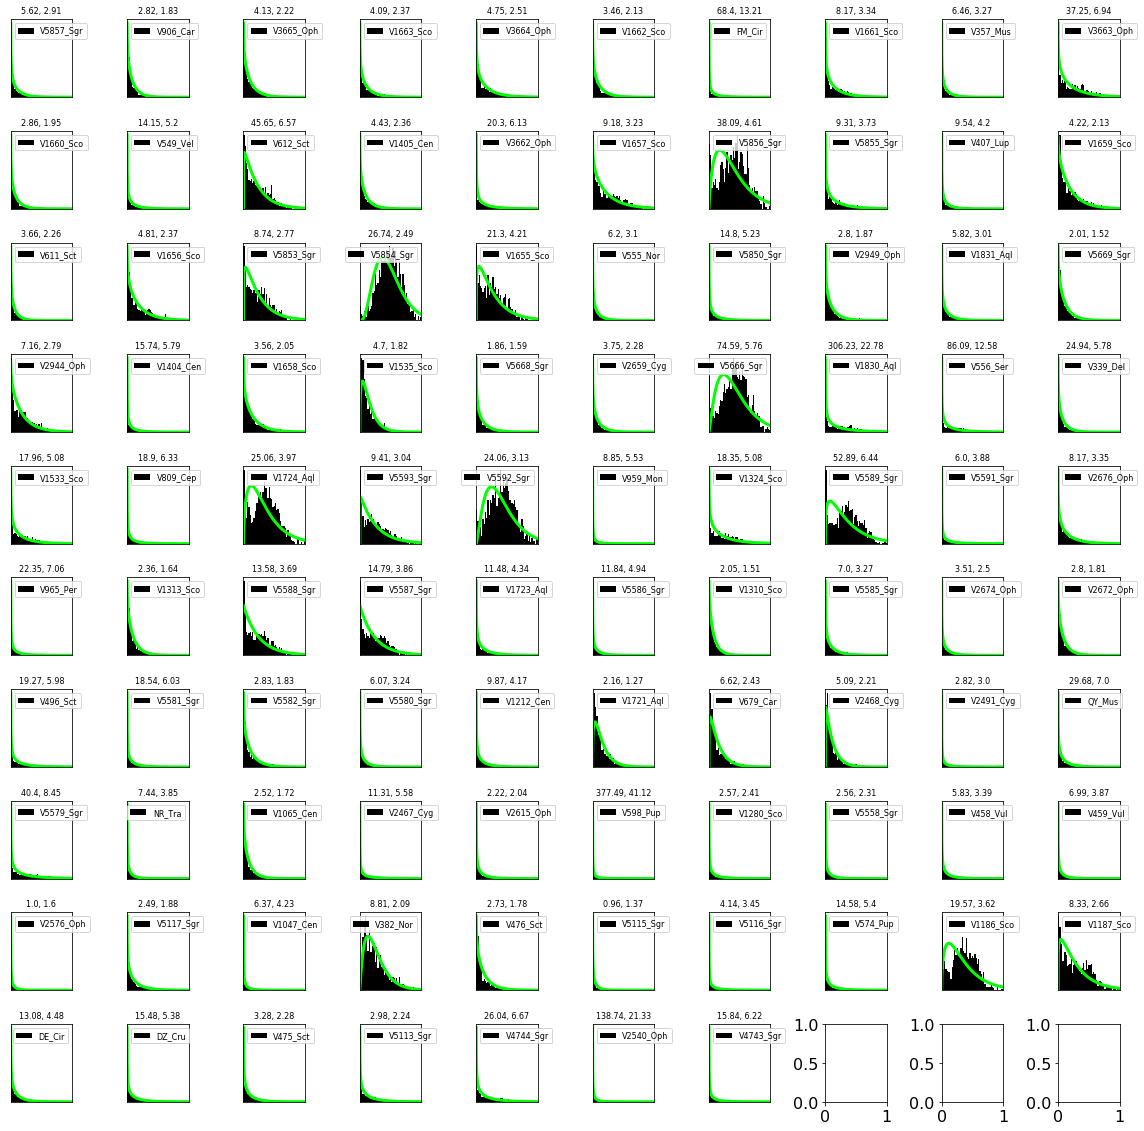

In [1252]:
flux_be7_posterior_alpha = []
flux_be7_posterior_beta = []


fig, ax = plt.subplots(10,10,figsize=(16,16))

cnt = 0
for i in tqdm(range(len(result_files_be7final))):
    with np.load(result_files_be7final[i]) as content:
        flux_tmp = content['fit_tmp_flux']
        dist_tmp = content['fit_tmp_dist']
        lgM_tmp = content['fit_tmp_lgM']   
        
        
    data_tmp = {"N":len(flux_tmp[:,0]),
                "y":flux_tmp[:,0]}
    
    fit_tmp = modelg.sampling(data=data_tmp,chains=1,iter=1000)
    
    ax_tmp = ax.ravel()[cnt]

    f_max = flux_tmp[:,0].max()
    
    ax_tmp.hist(flux_tmp[:,0],bins=np.linspace(0,f_max,50),density=True,
             label=result_files_final[i].split(results_dir)[1].split('/')[0][4:]);
    
    x = np.linspace(0,f_max,1000)
    
    ax_tmp.plot(x,plot_gamma(x,[fit_tmp['alpha'].mean(),1/fit_tmp['beta'].mean()]),color='lime',linewidth=3)
    ax_tmp.set_title(str(np.round(fit_tmp['alpha'].mean()/fit_tmp['beta'].mean(),2))+', '+\
                     str(np.round(np.sqrt(fit_tmp['beta'].mean())/fit_tmp['beta'].mean(),2)),fontsize=8)
    ax_tmp.set_xlim(0,f_max)
    ax_tmp.legend(fontsize=8)
    
    ax_tmp.set_xticks([])
    ax_tmp.set_yticks([])
    
    flux_be7_posterior_alpha.append(fit_tmp['alpha'].mean())
    flux_be7_posterior_beta.append(fit_tmp['beta'].mean())
    
    cnt += 1
    
plt.tight_layout()

flux_be7_posterior_alpha = np.array(flux_be7_posterior_alpha)
flux_be7_posterior_beta = np.array(flux_be7_posterior_beta)

In [1253]:
p2gfit_diff_be7 = \
"""
data {
 int<lower=1> N;              // Sample size
 real<lower=0> y[N];         // Outcome
}

parameters {
 real<lower=0> F_conti;
 real<lower=0> F_0;   // mean flux
 real<lower=0> F_err; // flux uncertainty
}

model {
 F_conti ~ normal(99.2,11.7);
 y ~ gamma((F_0+F_conti)*F_err, F_err); // fit for mean
}

"""

In [1254]:
modelg_diff_be7 = pystan.StanModel(model_code=p2gfit_diff_be7)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb5389cab433dfac383f31c1c4a88c79 NOW.


In [1266]:
with np.load(results_dir_be7+'000_Diffuse_Emission/save_StanFit_mass_NovaDiffuse_Emission_final.npz') as content:
    flux_tmp = content['fit_tmp_flux']

In [1267]:
data_diff_be7 = dict(N = len(flux_tmp[:,0]),
                      #y = np.abs(flux_tmp[:,0]-F_conti_set),
                      y = flux_tmp[:,0])

In [1268]:
fit_tmp = modelg_diff_be7.sampling(data=data_diff_be7,chains=1,iter=5000)
#fit_tmp = modelg.sampling(data=data_diff_na22,chains=1,iter=5000) # if prior "subtracted", which shouldn't be done

In [1269]:
fit_tmp

Inference for Stan model: anon_model_fb5389cab433dfac383f31c1c4a88c79.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
F_conti 100.14    0.36   8.02  85.82  93.85 100.18 106.47 114.33    484    1.0
F_0      16.16    0.36   8.03   2.02   9.79  16.09  22.46  30.57    486    1.0
F_err     1.16  1.8e-3   0.05   1.06   1.12   1.16   1.19   1.26    832    1.0
lp__     -3714    0.05   1.26  -3717  -3715  -3714  -3713  -3713    645    1.0

Samples were drawn using NUTS at Thu Nov 19 17:48:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Text(0, 0.5, 'P(Flux)')

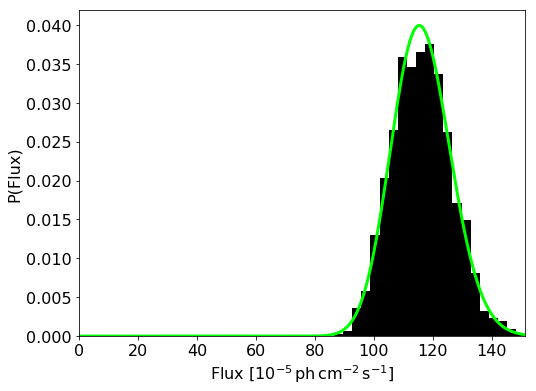

In [1270]:
x = np.linspace(0,flux_tmp[:,0].max(),1000)
#plt.hist(np.abs(flux_tmp[:,0]-F_conti_set),bins=np.linspace(0,flux_tmp[:,0].max(),50),density=True);
plt.hist(flux_tmp[:,0],bins=np.linspace(0,flux_tmp[:,0].max(),50),density=True);
#plt.plot(x,plot_gamma(x,[fit_tmp['alpha'].mean(),1/fit_tmp['beta'].mean()]),color='lime',linewidth=3)
plt.plot(x,plot_gamma(x,[(fit_tmp['F_0'].mean()+fit_tmp['F_conti'].mean())*fit_tmp['F_err'].mean(),
                         1/fit_tmp['F_err'].mean()]),color='lime',linewidth=3)
#plt.yscale('log')
plt.xlim(0,flux_tmp[:,0].max())
plt.xlabel(r'Flux [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylabel(r'P(Flux)')


<h3>Not optimal but gives an appropriate tail.</h3>

In [1271]:
# upper limit if "subtracted"
np.percentile(np.abs(flux_tmp[:,0]-F_conti_set),99.85)

59.839685516279

<h3>And if we include the gamma-dsitribution to calculate the upper bound:</h3>

In [1272]:
#gamma.ppf(0.5+0.9973/2,fit_tmp['alpha'].mean(),scale=1/fit_tmp['beta'].mean())
gamma.ppf(0.9985,fit_tmp['F_0'].mean()*fit_tmp['F_err'].mean(),scale=1/fit_tmp['F_err'].mean())

29.497106836871165

<h3>somewhat higher than highest sampled point: conservative limit</h3>

In [1273]:
# mean
#gamma.mean(fit_tmp['alpha'].mean(),scale=1/fit_tmp['beta'].mean())
gamma.mean(fit_tmp['F_0'].mean()*fit_tmp['F_err'].mean(),scale=1/fit_tmp['F_err'].mean())

16.15583880403118

In [1274]:
# std
#gamma.std(fit_tmp['alpha'].mean(),scale=1/fit_tmp['beta'].mean())
gamma.std(fit_tmp['F_0'].mean()*fit_tmp['F_err'].mean(),scale=1/fit_tmp['F_err'].mean())

3.7335263503734035

In [1277]:
fit_tmp['F_0'].mean()*fit_tmp['F_err'].mean(),fit_tmp['F_err'].mean()

(18.72494630399151, 1.159020372208671)

<h3>We extend the array by the solution from the diffuse emission:</h3>

In [1278]:
flux_be7_posterior_alpha_all = np.concatenate([flux_be7_posterior_alpha,np.array([18.72494630399151])])
flux_be7_posterior_beta_all = np.concatenate([flux_be7_posterior_beta,np.array([1.159020372208671])])

In [1283]:
be7_no_pooling_srcs =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
 
    // ejected mass
    real mu_lgM;                   // prior for the log mass of ALL objects
    real sigma_lgM;                // width of log mass prior
    real lgM_min;                  // lower bound of sampling region of lgM (to avoid uninteresting regions)
 
    // if distance is not known, use global distrribution, approximated by gamma distribution with fixed parameters
    real distance_alpha[N-1];      // gamma distribution alpha parameter for distance; or mean of normal distribution
    real distance_beta[N-1];       // gamma distribution beta parameters (=1/theta) for distance; or width of normal distribution
    int known_dist_idx[N];         // index for objects with known distance (diffuse distance known)
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;         // flux means
    // vector[N] flux_stds = sqrt(fluxes_alpha) ./ fluxes_beta; // not needed
    
    print(flux_means); // cross check
}

parameters {
    real<lower=lgM_min,upper=-4> lgM[N];  // mass for each object
    real<lower=0.1,upper=40.0> dist[N-1]; // distance for each object
    real<lower=1.,upper=150.> R_CN;       // nota rate for diffuse emission
}


transformed parameters {

    real flux[N]; // calculate flux

    for (n in 1:N) {

        if (known_dist_idx[n] < 2) { // flag for point source (0 or 1) or diffuse (2)
        
            flux[n] = exp(21.5461 + 2.3026*lgM[n] - 2*log(dist[n]));

        } else {

            flux[n] = exp(16.6713 + 2.3026*lgM[n] + log(R_CN));

        }

    }

}


model {
    
    lgM ~ normal(mu_lgM,sigma_lgM);                              // normal prior(s) for log mass

    for (n in 1:N-1) { // loop over objects

        if (known_dist_idx[n] == 1) { // if distance known, use gaussian prior

            dist[n] ~ normal(distance_alpha[n],distance_beta[n]);

        } else { // if not generic gamma prior

            dist[n] ~ gamma(4.25,0.408);                        // gamma prior(s) for the dist

        }

    }

    # Shafter+2017 nova rate 50+25/yr for CO novae (~1/3 for ONe novae, there fore use 17+-8)
    R_CN ~ normal(50.,25.); // ONe nova rate
    
    
    
    for (n in 1:N) {
        flux_means[n] ~ gamma(flux[n]*fluxes_beta[n], fluxes_beta[n]);
    }
    
}

"""

In [1284]:
be7_complete_pooling_srcs =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
 
    // ejected mass
    real mu_lgM;                   // prior for the log mass of ALL objects
    real sigma_lgM;                // width of log mass prior
    real lgM_min;                  // lower bound of sampling region of lgM (to avoid uninteresting regions)
 
    // if distance is not known, use global distrribution, approximated by gamma distribution with fixed parameters
    real distance_alpha[N-1];      // gamma distribution alpha parameter for distance; or mean of normal distribution
    real distance_beta[N-1];       // gamma distribution beta parameters (=1/theta) for distance; or width of normal distribution
    int known_dist_idx[N];         // index for objects with known distance (diffuse distance known)
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;         // flux means
    // vector[N] flux_stds = sqrt(fluxes_alpha) ./ fluxes_beta; // not needed
    
    print(flux_means); // cross check
}

parameters {
    real<lower=lgM_min,upper=-4> lgM;  // mass for each object
    real<lower=0.1,upper=40.0> dist[N-1]; // distance for each object
    real<lower=1.,upper=150.> R_CN;       // nota rate for diffuse emission
}


transformed parameters {

    real flux[N]; // calculate flux

    for (n in 1:N) {

        if (known_dist_idx[n] < 2) { // flag for point source (0 or 1) or diffuse (2)
        
            flux[n] = exp(21.5461 + 2.3026*lgM - 2*log(dist[n]));

        } else {

            flux[n] = exp(16.6713 + 2.3026*lgM + log(R_CN));

        }

    }

}


model {
    
    lgM ~ normal(mu_lgM,sigma_lgM);                              // normal prior(s) for log mass

    for (n in 1:N-1) { // loop over objects

        if (known_dist_idx[n] == 1) { // if distance known, use gaussian prior

            dist[n] ~ normal(distance_alpha[n],distance_beta[n]);

        } else { // if not generic gamma prior

            dist[n] ~ gamma(4.25,0.408);                        // gamma prior(s) for the dist

        }

    }

    # Shafter+2017 nova rate 50+25/yr for CO novae (~1/3 for ONe novae, there fore use 17+-8)
    R_CN ~ normal(50.,25.); // ONe nova rate
    
    
    
    for (n in 1:N) {
        flux_means[n] ~ gamma(flux[n]*fluxes_beta[n], fluxes_beta[n]);
    }
    
}

"""

In [1285]:
be7_partial_pooling_srcs =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
 
    // ejected mass
    real lgM_min;                  // lower bound of sampling region of lgM (to avoid uninteresting regions)
 
    // if distance is not known, use global distrribution, approximated by gamma distribution with fixed parameters
    real distance_alpha[N-1];      // gamma distribution alpha parameter for distance; or mean of normal distribution
    real distance_beta[N-1];       // gamma distribution beta parameters (=1/theta) for distance; or width of normal distribution
    int known_dist_idx[N];         // index for objects with known distance (diffuse distance known)
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;
    // vector[N] flux_stds = 3.5 * sqrt(fluxes_alpha) ./ fluxes_beta;
}

parameters {
    real<lower=lgM_min,upper=-4> mu_lgM;
    real<lower=0> tau_lgM;
    vector[N] eta;
    real<lower=0.1,upper=40.0> dist[N-1];
    real<lower=1.,upper=150.> R_CN;
}


transformed parameters {

    real flux[N]; // calculate flux

    vector[N] lgM;
    lgM = mu_lgM + tau_lgM * eta;

    for (n in 1:N) {

        if (known_dist_idx[n] < 2) { // flag for point source (0 or 1) or diffuse (2)

            flux[n] = exp(21.5461 + 2.3026*lgM[n] - 2*log(dist[n]));

        } else {

            flux[n] = exp(16.6713 + 2.3026*lgM[n] + log(R_CN));

        }

    }

}


model {
    eta ~ normal(0, 1);
    mu_lgM ~ uniform(-20,-4);
    tau_lgM ~ cauchy(0,1);
    // tau_lgM ~ uniform(0,10);
    //lgM ~ normal(mu_lgM,tau_lgM);                              // normal prior(s) for log mass

    for (n in 1:N-1) {

        if (known_dist_idx[n] == 1) {

            dist[n] ~ normal(distance_alpha[n],distance_beta[n]);

        } else {

            dist[n] ~ gamma(4.25,0.408);                        // gamma prior(s) for the dist

        }

    }

    # Shafter+2017 nova rate 50+25/yr for CO novae (~1/3 for ONe novae, there fore use 17+-8)
    R_CN ~ normal(50.,25.);
    
    
    
    for (n in 1:N) {
        flux_means[n] ~ gamma(flux[n]*fluxes_beta[n], fluxes_beta[n]);
    }
    
    
}

"""

In [1291]:
data   = dict(N               = len(flux_be7_posterior_alpha_all),
              fluxes_alpha    = flux_be7_posterior_alpha_all,
              fluxes_beta     = flux_be7_posterior_beta_all,
              mu_lgM          = -10,
              sigma_lgM       = 100,
              lgM_min         = -20,
              distance_alpha  = dist_arr,
              distance_beta   = dist_arr_err,
              known_dist_idx  = known_dist_idx.astype(int))

In [1287]:
model_np_lgm_be7 = pystan.StanModel(model_code=be7_no_pooling_srcs)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_477419225aa08e90394d56da7bb27e13 NOW.


In [1288]:
model_cp_lgm_be7 = pystan.StanModel(model_code=be7_complete_pooling_srcs)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_53dbb7af14610c2d4b7b14d472a08901 NOW.


In [1289]:
model_pp_lgm_be7 = pystan.StanModel(model_code=be7_partial_pooling_srcs)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dafafb271696824f513a8abeaed9aabb NOW.


In [1292]:
fit_np_lgm_be7 = model_np_lgm_be7.sampling(data=data,chains=1,iter=10000,control={"adapt_delta":0.95})

In [1307]:
print(fit_np_lgm_be7.stansummary(['lgM[1]','flux[1]','lp__'],probs=[0.0015,0.5,0.9985]))

Inference for Stan model: anon_model_477419225aa08e90394d56da7bb27e13.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

          mean se_mean     sd  0.15%    50% 99.85%  n_eff   Rhat
lgM[1]    -6.7  8.5e-3   0.65  -9.25  -6.64  -5.17   5853    1.0
flux[1]   8.07    0.09   6.39   0.03   6.64  35.28   4932    1.0
lp__     85.25    0.29  11.31  48.05  85.72 116.61   1506    1.0

Samples were drawn using NUTS at Thu Nov 19 18:02:26 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [1308]:
#mass_limits_be7

In [1309]:
#10**np.percentile(fit_np_lgm_be7['lgM'],99.85,axis=0)[0:]

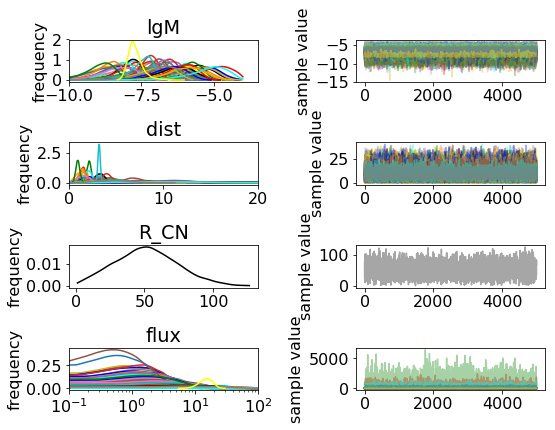

In [1299]:
np_plot = fit_np_lgm_be7.plot();

np_plot.axes[0].set_xlim(-10,)
np_plot.axes[2].set_xlim(0,20)
np_plot.axes[6].set_xscale('log')
np_plot.axes[6].set_xlim(0.1,100)

plt.tight_layout()

In [1300]:
fit_cp_lgm_be7 = model_cp_lgm_be7.sampling(data=data,chains=10,iter=10000,control={"adapt_delta":0.95})

In [1304]:
print(fit_cp_lgm_be7.stansummary(['lgM','lp__'],probs=[0.0015,0.5,0.9985]))

Inference for Stan model: anon_model_53dbb7af14610c2d4b7b14d472a08901.
10 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=50000.

       mean se_mean     sd  0.15%    50% 99.85%  n_eff   Rhat
lgM   -7.41  3.2e-4   0.05  -7.57  -7.41  -7.26  25673    1.0
lp__ -104.7    0.05   6.99 -128.5 -104.3 -86.69  21086    1.0

Samples were drawn using NUTS at Thu Nov 19 18:06:14 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [1306]:
print('Upper bound on ejected Be-7 mass (x 1e-8 Msun) from nova population: '+\
      str('%.1f' % (10**np.percentile(fit_cp_lgm_be7['lgM'],99.85)*1e8)+'.'))

Upper bound on ejected Be-7 mass (x 1e-8 Msun) from nova population: 5.5.


In [1313]:
mass_limits_be7.min()*1e8

0.9661501431168282

In [1311]:
data_pp_be7 = dict(N          = len(flux_be7_posterior_alpha_all),
              fluxes_alpha    = flux_be7_posterior_alpha_all,
              fluxes_beta     = flux_be7_posterior_beta_all,
              lgM_min         = -20,
              distance_alpha  = dist_arr,
              distance_beta   = dist_arr_err,
              known_dist_idx  = known_dist_idx.astype(int))

In [1312]:
fit_pp_lgm_be7 = model_pp_lgm_be7.sampling(data=data_pp_be7,chains=10,iter=20000,control={"adapt_delta":0.95})

In [1314]:
print(fit_pp_lgm_be7.stansummary(['mu_lgM','tau_lgM','lgM[1]','flux[1]','lp__'],probs=[0.0015,0.5,0.9985]))

Inference for Stan model: anon_model_dafafb271696824f513a8abeaed9aabb.
10 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=100000.

          mean se_mean     sd  0.15%    50% 99.85%  n_eff   Rhat
mu_lgM   -6.89  3.9e-4   0.09  -7.17  -6.89  -6.61  58311    1.0
tau_lgM    0.7  3.6e-4   0.08    0.5   0.69   0.95  44997    1.0
lgM[1]   -6.74  1.4e-3   0.47  -8.32  -6.72  -5.49 112341    1.0
flux[1]   7.47    0.02   5.73   0.14   6.08  33.55 127648    1.0
lp__    -30.12    0.08  12.58 -69.17 -29.85   4.91  25705    1.0

Samples were drawn using NUTS at Thu Nov 19 18:12:28 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [1319]:
be7_partial_pooling_srcs_calc_tau =\
"""

data {
    int<lower=0> N; // number of sources
    vector[N] fluxes_alpha; // gamma posterior alpha for each source
    vector[N] fluxes_beta;  // gamma posterior beta for each source
 
    // ejected mass
    real lgM_min;                  // lower bound of sampling region of lgM (to avoid uninteresting regions)
 
    // if distance is not known, use global distrribution, approximated by gamma distribution with fixed parameters
    real distance_alpha[N-1];      // gamma distribution alpha parameter for distance; or mean of normal distribution
    real distance_beta[N-1];       // gamma distribution beta parameters (=1/theta) for distance; or width of normal distribution
    int known_dist_idx[N];         // index for objects with known distance (diffuse distance known)
    
    real tau_lgM;  // for calculation?
}

transformed data {
    vector[N] flux_means = fluxes_alpha ./ fluxes_beta;
    // vector[N] flux_stds = 3.5 * sqrt(fluxes_alpha) ./ fluxes_beta;
}

parameters {
    real<lower=lgM_min,upper=-4> mu_lgM;
    //real<lower=0> tau_lgM;
    vector[N] eta;
    real<lower=0.1,upper=40.0> dist[N-1];
    real<lower=1.,upper=150.> R_CN;
}


transformed parameters {

    real flux[N]; // calculate flux

    vector[N] lgM;
    lgM = mu_lgM + tau_lgM * eta;

    for (n in 1:N) {

        if (known_dist_idx[n] < 2) { // flag for point source (0 or 1) or diffuse (2)

            flux[n] = exp(21.5461 + 2.3026*lgM[n] - 2*log(dist[n]));

        } else {

            flux[n] = exp(16.6713 + 2.3026*lgM[n] + log(R_CN));

        }

    }

}


model {
    eta ~ normal(0, 1);
    mu_lgM ~ uniform(-20,-4);
    tau_lgM ~ cauchy(0,1);
    // tau_lgM ~ uniform(0,10);
    //lgM ~ normal(mu_lgM,tau_lgM);                              // normal prior(s) for log mass

    for (n in 1:N-1) {

        if (known_dist_idx[n] == 1) {

            dist[n] ~ normal(distance_alpha[n],distance_beta[n]);

        } else {

            dist[n] ~ gamma(4.25,0.408);                        // gamma prior(s) for the dist

        }

    }

    # Shafter+2017 nova rate 50+25/yr for CO novae (~1/3 for ONe novae, there fore use 17+-8)
    R_CN ~ normal(50.,25.);
    
    
    
    for (n in 1:N) {
        flux_means[n] ~ gamma(flux[n]*fluxes_beta[n], fluxes_beta[n]);
    }
    
    
}

"""

In [1320]:
model_pp_lgm_be7_tau = pystan.StanModel(model_code=be7_partial_pooling_srcs_calc_tau)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_11b18aa2ce1d76a3bd1067d4f4b28514 NOW.


<h3>50 logarithmically binned $\tau$ values between $0.01$ and $10$.</h3>

In [1321]:
tau_arr_pp = np.logspace(-2,1,50)
tau_arr_pp

array([ 0.01      ,  0.01151395,  0.01325711,  0.01526418,  0.01757511,
        0.0202359 ,  0.02329952,  0.02682696,  0.03088844,  0.0355648 ,
        0.04094915,  0.04714866,  0.05428675,  0.06250552,  0.07196857,
        0.08286428,  0.09540955,  0.10985411,  0.12648552,  0.14563485,
        0.16768329,  0.19306977,  0.22229965,  0.25595479,  0.29470517,
        0.33932218,  0.39069399,  0.44984327,  0.51794747,  0.59636233,
        0.68664885,  0.79060432,  0.91029818,  1.04811313,  1.20679264,
        1.38949549,  1.59985872,  1.84206997,  2.12095089,  2.44205309,
        2.8117687 ,  3.23745754,  3.72759372,  4.29193426,  4.94171336,
        5.68986603,  6.55128557,  7.54312006,  8.68511374, 10.        ])

<h3>Loop over $\tau$-values:</h3>

In [1322]:
N_src = 98
N_tau = len(tau_arr_pp)

lgM_be7_arr_median = np.zeros((N_src,N_tau))
lgM_be7_arr_ub = np.zeros((N_src,N_tau))

lgM_be7_arr_mu_median = np.zeros(N_tau)
lgM_be7_arr_mu_ub = np.zeros(N_tau)

for i in tqdm(range(N_tau)):
    data_pp_tau = dict(N               = len(flux_be7_posterior_alpha_all),
                       fluxes_alpha    = flux_be7_posterior_alpha_all,
                       fluxes_beta     = flux_be7_posterior_beta_all,
                       lgM_min         = -20, # we use a very low limit to not disturb anything
                       distance_alpha  = dist_arr,
                       distance_beta   = dist_arr_err,
                       known_dist_idx  = known_dist_idx.astype(int),
                       tau_lgM         = tau_arr_pp[i])
    
    fit_pp_lgm_be7_tau = model_pp_lgm_be7_tau.sampling(data=data_pp_tau,chains=10,iter=2000)
    
    lgM_be7_arr_median[:,i] = np.percentile(fit_pp_lgm_be7_tau['lgM'],50,axis=0)
    lgM_be7_arr_ub[:,i] = np.percentile(fit_pp_lgm_be7_tau['lgM'],99.85,axis=0)
    
    lgM_be7_arr_mu_median[i] = np.percentile(fit_pp_lgm_be7_tau['mu_lgM'],50)
    lgM_be7_arr_mu_ub[i] = np.percentile(fit_pp_lgm_be7_tau['mu_lgM'],99.85)

<h3>Fancy plot showing the funnel and the posterior of $\tau$:</h3>

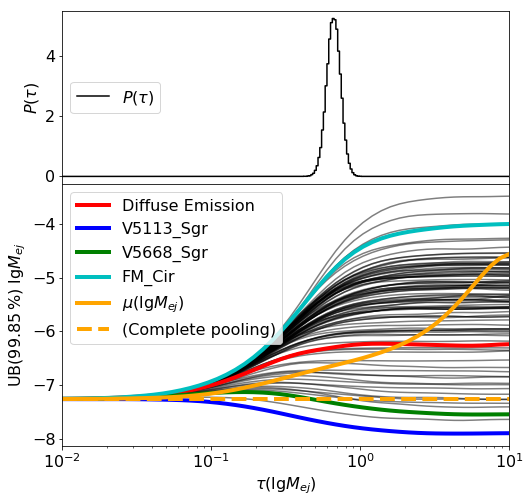

In [1323]:
tau_bins = np.logspace(-2,10,1000)
tau_dat = np.histogram(fit_pp_lgm_be7['tau_lgM'],bins=tau_bins,density=True);


fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,8),gridspec_kw={'height_ratios':[1.33,2]})#,subplot_kw={"aspect":0.33})

sf = 2.5
ax[1].plot(tau_arr_pp,smooth(lgM_be7_arr_ub.T,2,axis=0),'k-',alpha=0.5);
ax[1].plot(tau_arr_pp,smooth(lgM_be7_arr_ub[97,:],sf),'r-',linewidth=4,label='Diffuse Emission');
ax[1].plot(tau_arr_pp,smooth(lgM_be7_arr_ub[93,:],sf),'b-',linewidth=4,label='V5113_Sgr');
ax[1].plot(tau_arr_pp,smooth(lgM_be7_arr_ub[34,:],sf),'g-',linewidth=4,label='V5668_Sgr');
ax[1].plot(tau_arr_pp,smooth(lgM_be7_arr_ub[6,:],sf),'c-',linewidth=4,label='FM_Cir');
ax[1].plot(tau_arr_pp,smooth(lgM_be7_arr_mu_ub,sf),color='orange',linestyle='-',linewidth=4,
           label=r'$\mu(\lg M_{ej} )$');
ax[1].axhline(np.percentile(fit_cp_lgm_be7['lgM'],99.85),color='orange',linestyle='--',linewidth=4,
              label=r'(Complete pooling)')

ax[1].set_xscale('log')
ax[1].set_xlim(1e-2,10)
#ax[1].set_xlim(0,2)
ax[1].set_xlabel(r'$\tau(\lg M_{ej} )$')
ax[1].set_ylabel(r'UB(99.85$\,\%$) $\lg M_{ej}$')


ax[1].legend()


plt.subplots_adjust(hspace=0)

ax[0].step(tau_dat[1][0:-1],tau_dat[0],where='pre',label=r'$P(\tau)$')

#ax[0].plot(x,truncated_cauchy(x,[0,2,0,np.inf]),color='red',linestyle='--',label=r'$\mathscr{C}_{0}^{+}(0,2)$')
#ax[0].plot(x,np.repeat(0.1,len(x)),color='red',label=r'$\mathscr{U}(0,10)$')

ax[0].set_ylabel(r'$P(\tau)$')
ax[0].set_xscale('log')
ax[0].set_xlim(1e-2,10)
#ax[0].set_xlim(0,2)
#ax[0].set_ylim(0,0.39)
ax[0].set_xticks([])

ax[0].legend(loc=6)

plt.savefig('Hierarchical_Model_Posterior_Bounds_Tau_Be7.pdf')

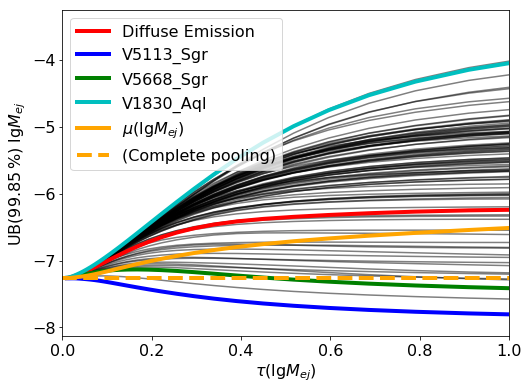

In [1326]:
tau_bins = np.logspace(-2,10,1000)
tau_dat = np.histogram(fit_pp_lgm_be7['tau_lgM'],bins=tau_bins,density=True);


fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))#,gridspec_kw={'height_ratios':[1.33,2]})#,subplot_kw={"aspect":0.33})

sf = 2.5
ax.plot(tau_arr_pp,smooth(lgM_be7_arr_ub.T,2,axis=0),'k-',alpha=0.5);
ax.plot(tau_arr_pp,smooth(lgM_be7_arr_ub[97,:],sf),'r-',linewidth=4,label='Diffuse Emission');
ax.plot(tau_arr_pp,smooth(lgM_be7_arr_ub[93,:],sf),'b-',linewidth=4,label='V5113_Sgr');
ax.plot(tau_arr_pp,smooth(lgM_be7_arr_ub[34,:],sf),'g-',linewidth=4,label='V5668_Sgr');
ax.plot(tau_arr_pp,smooth(lgM_be7_arr_ub[37,:],sf),'c-',linewidth=4,label='V1830_Aql');
ax.plot(tau_arr_pp,smooth(lgM_be7_arr_mu_ub,sf),color='orange',linestyle='-',linewidth=4,
           label=r'$\mu(\lg M_{ej} )$');
ax.axhline(np.percentile(fit_cp_lgm_be7['lgM'],99.85),color='orange',linestyle='--',linewidth=4,
              label=r'(Complete pooling)')

#ax.set_xscale('log')
#ax.set_xlim(1e-2,10)
ax.set_xlim(0,1)
ax.set_xlabel(r'$\tau(\lg M_{ej} )$')
ax.set_ylabel(r'UB(99.85$\,\%$) $\lg M_{ej}$')


ax.legend()


plt.savefig('Hierarchical_Model_Posterior_Be7.pdf')

In [1185]:
fin_mix_mod = \
"""

data {
  int<lower=1> K;          // number of mixture components
  int<lower=1> N;          // number of data points
  real y[N];               // observations
}
transformed data {
  simplex[2] theta;
  theta[1] = 0.3;
  theta[2] = 0.7;
}
parameters {
  //simplex[K] theta;          // mixing proportions
  ordered[K] mu;             // locations of mixture components
  vector<lower=0>[K] sigma;  // scales of mixture components
}
model {

  vector[K] log_theta = log(theta);  // cache log calculation
  //sigma ~ lognormal(0, 2);
  //mu ~ normal(0, 10);
  for (n in 1:N) {
    vector[K] lps = log_theta;
    for (k in 1:K)
      lps[k] += normal_lpdf(y[n] | mu[k], sigma[k]);
    target += log_sum_exp(lps);
  }
}

"""

In [1186]:
model_fmm = pystan.StanModel(model_code=fin_mix_mod)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80459b03f2c1e219728a97ef68b4e9d0 NOW.


In [1200]:
y = np.concatenate([np.random.randn(100)*2-3,
                    np.random.randn(1000)*2+3])

In [1201]:
data_y = dict(K = 2,
              N = len(y),
              y = y)

In [1202]:
fit1 = model_fmm.sampling(data=data_y,chains=1,iter=1000)

In [1203]:
fit1

Inference for Stan model: anon_model_80459b03f2c1e219728a97ef68b4e9d0.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      0.58    0.02   0.27   0.02   0.39   0.58   0.77   1.09    155    1.0
mu[2]      3.15  5.5e-3   0.09   2.98   3.09   3.15   3.21   3.33    279    1.0
sigma[1]   3.42    0.01   0.17   3.11    3.3    3.4   3.53   3.77    190    1.0
sigma[2]    1.8  3.7e-3   0.06   1.68   1.75    1.8   1.84   1.92    272    1.0
lp__      -2564    0.11   1.48  -2567  -2564  -2563  -2562  -2562    193    1.0

Samples were drawn using NUTS at Mon Nov 16 11:59:04 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [1204]:
def Gaussian(x,p):
    mu = p[0]
    sigma = p[1]
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*(x-mu)**2/sigma**2)

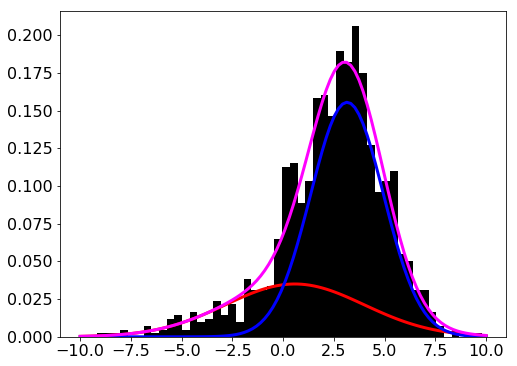

In [1205]:
plt.hist(y,bins=50,density=True);
x2 = np.linspace(-10,10,100)
#g1 = fit1['theta[1]'].mean()*Gaussian(x2,[fit1['mu[1]'].mean(),fit1['sigma[1]'].mean()])
#g2 = fit1['theta[2]'].mean()*Gaussian(x2,[fit1['mu[2]'].mean(),fit1['sigma[2]'].mean()])
g1 = 0.3*Gaussian(x2,[fit1['mu[1]'].mean(),fit1['sigma[1]'].mean()])
g2 = 0.7*Gaussian(x2,[fit1['mu[2]'].mean(),fit1['sigma[2]'].mean()])
plt.plot(x2,g1,color='red',linewidth=3)
plt.plot(x2,g2,color='blue',linewidth=3)
plt.plot(x2,g1+g2,color='magenta',linewidth=3)